# Importing requirements and loading log file.

In [3]:
import pm4py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from scipy.stats import chi2_contingency
from wordcloud import WordCloud
import numpy as np

In [4]:
# logPath="Sepsis Cases - Event Log.xes"
logPath="Road_Traffic_Fine_Management_Process.xes"
log = pm4py.read_xes(logPath)
df = pm4py.convert_to_dataframe(log)
log['time:timestamp']= pd.to_datetime(log['time:timestamp'])

C:\Users\Robin_T480\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|███████████████████████████████████████| 150370/150370 [00:31<00:00, 4750.53it/s]


In [143]:
df

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.00,NaN,NaN,NaN,NaN
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.00,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561465,131.0,25,NIL,Create Fine,A,0.0,complete,2002-09-07 00:00:00+00:00,142.0,0.0,V9999,NaN,NaN,NaN,NaN,NaN
561466,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2002-10-25 00:00:00+00:00,NaN,NaN,V9999,15.16,NaN,NaN,NaN,NaN
561467,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2002-11-04 00:00:00+00:00,NaN,NaN,V9999,NaN,P,N,NaN,NaN
561468,262.0,NaN,NaN,Add penalty,NaN,NaN,complete,2003-01-03 00:00:00+00:00,NaN,NaN,V9999,NaN,NaN,NaN,NaN,NaN


In [144]:
df["concept:name"].unique()

array(['Create Fine', 'Send Fine', 'Insert Fine Notification',
       'Add penalty', 'Send for Credit Collection', 'Payment',
       'Insert Date Appeal to Prefecture', 'Send Appeal to Prefecture',
       'Receive Result Appeal from Prefecture',
       'Notify Result Appeal to Offender', 'Appeal to Judge'],
      dtype=object)

# Exploring log file

in the first step, we check frequency of each variant.

In [145]:
variants = pm4py.get_variants(log)
variants = sorted(variants.items(), key=lambda x: x[1],reverse=True)

The variants are sorted based on the frequency, we draw the bar chart for variant frequency of the first 100 variants.

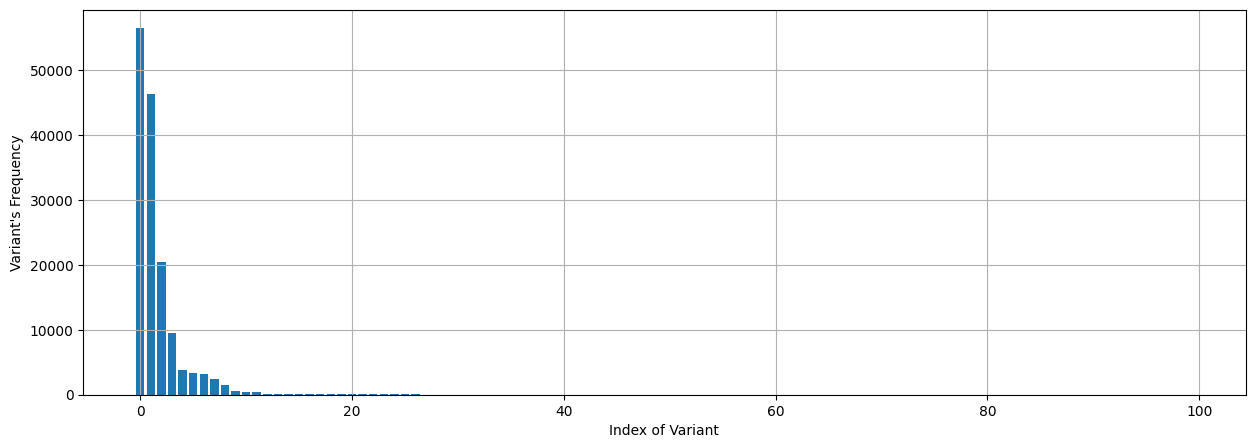

In [161]:
values = [item[1] for item in variants[:100]]
plt.figure(figsize=(15, 5))
plt.grid()
plt.xlabel('Index of Variant')
plt.ylabel('Variant\'s Frequency')
plt.bar(range(len(values)), values)
plt.show()

now we try to find out how many variants we need to obtain 90% of information stored in log file.

In [147]:
variants[:5]

[(('Create Fine',
   'Send Fine',
   'Insert Fine Notification',
   'Add penalty',
   'Send for Credit Collection'),
  56482),
 (('Create Fine', 'Payment'), 46371),
 (('Create Fine', 'Send Fine'), 20385),
 (('Create Fine',
   'Send Fine',
   'Insert Fine Notification',
   'Add penalty',
   'Payment'),
  9520),
 (('Create Fine',
   'Send Fine',
   'Insert Fine Notification',
   'Add penalty',
   'Payment',
   'Payment'),
  3736)]

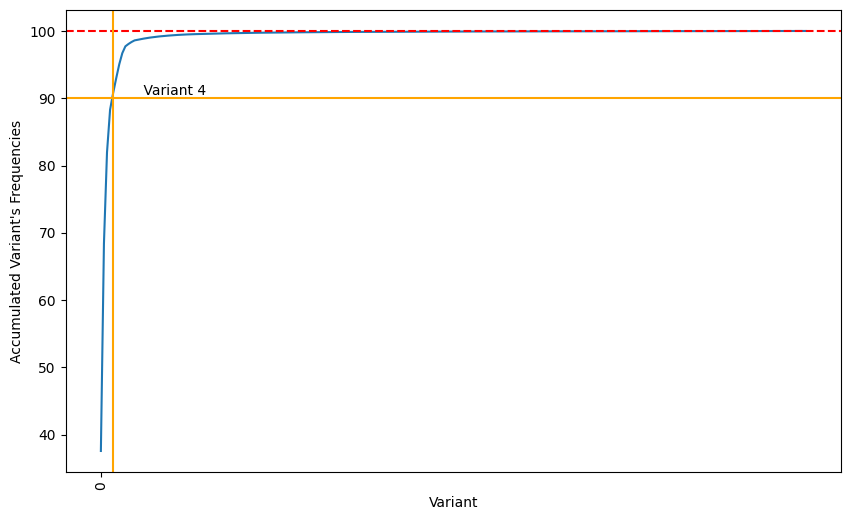

In [148]:
total_frequency = sum(value for _, value in variants)
accumulated_frequencies = []
accumulated_frequency = 0

for _, value in variants:
    accumulated_frequency += value
    accumulated_frequencies.append( (accumulated_frequency/total_frequency) * 100)

plt.figure(figsize=(10, 6))
plt.plot(range(len(accumulated_frequencies)), accumulated_frequencies)
plt.xlabel('Variant')
plt.ylabel('Accumulated Variant\'s Frequencies')
plt.xticks(range(0, len(accumulated_frequencies), 500), rotation=90)
plt.axhline(y=100, color='r', linestyle='--')
plt.axhline(y=90, color='orange', linestyle='-')
index_90 = min(range(len(accumulated_frequencies)), key=lambda i: abs(accumulated_frequencies[i] - 90))
plt.axvline(x=index_90, color='orange', linestyle='-')
plt.text(index_90, 90, f'                            Variant {index_90}', ha='center', va='bottom')

plt.show()

In [149]:
accumulated_frequencies[5]

92.9673472102148

accumulative frequency of top 5 variants is 93%
Another aspect to consider is activity frequency. we compute frequency of activities:




In [150]:
frequency = df["concept:name"].value_counts().reset_index()
frequency.columns = ["concept:name", "Frequency"]
total = frequency["Frequency"].sum()
frequency["Percentage"] = frequency["Frequency"] / total * 100
frequency.index = frequency.index + 1
frequency[:10]

,concept:name,Frequency,Percentage
1,Create Fine,150370,26.781484
2,Send Fine,103987,18.520491
3,Insert Fine Notification,79860,14.223378
4,Add penalty,79860,14.223378
5,Payment,77601,13.821041
6,Send for Credit Collection,59013,10.510446
7,Insert Date Appeal to Prefecture,4188,0.745899
8,Send Appeal to Prefecture,4141,0.737528
9,Receive Result Appeal from Prefecture,999,0.177926
10,Notify Result Appeal to Offender,896,0.159581


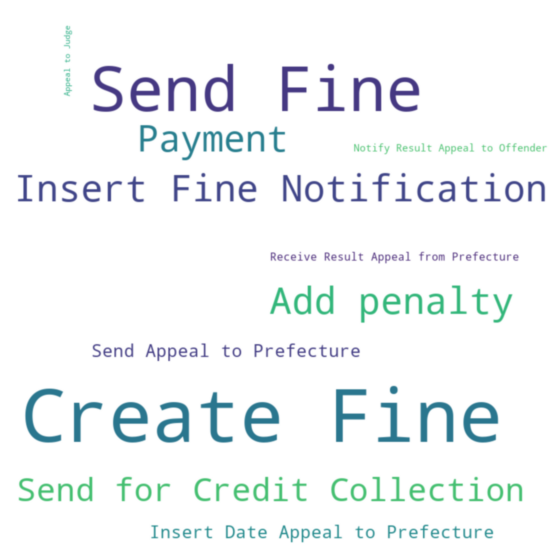

In [155]:
# to understand it better, we try to generate a word cloud chart as well:
keyword_data =frequency.set_index('concept:name')['Frequency'].to_dict()
wordcloud = WordCloud(background_color='white', width=800, height=800)
wordcloud.generate_from_frequencies(keyword_data)
plt.figure(figsize=(7, 7))
plt.imshow(wordcloud, interpolation='bicubic')
plt.axis('off')
plt.show()

It is a good consideration to check the list of start and end activities. we can use this list to detect some anomalies and use it during filtering phase:


In [156]:
log_start = pm4py.get_start_activities(log)
log_end = pm4py.get_end_activities(log)

In [157]:
log_start

{'Create Fine': 150370}

In [158]:
log_end

{'Send Fine': 20755,
 'Send for Credit Collection': 58997,
 'Payment': 67201,
 'Send Appeal to Prefecture': 3144,
 'Appeal to Judge': 134,
 'Notify Result Appeal to Offender': 86,
 'Receive Result Appeal from Prefecture': 53}

Another aspect to consider is case duration to be complete. it is also knows as performance.

number of cases:  150370


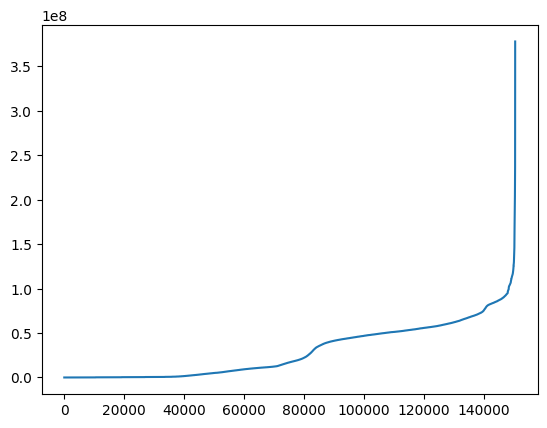

In [159]:
durations = pm4py.get_all_case_durations(log)
print("number of cases: ",len(durations))
x_values = range(len(durations))
plt.plot(x_values, durations)
plt.show()

Another aspect to consider is frequency of each four category. according to the documentation we have four categories. we try to illustrate the frequency of each one by drawing a bar chart:

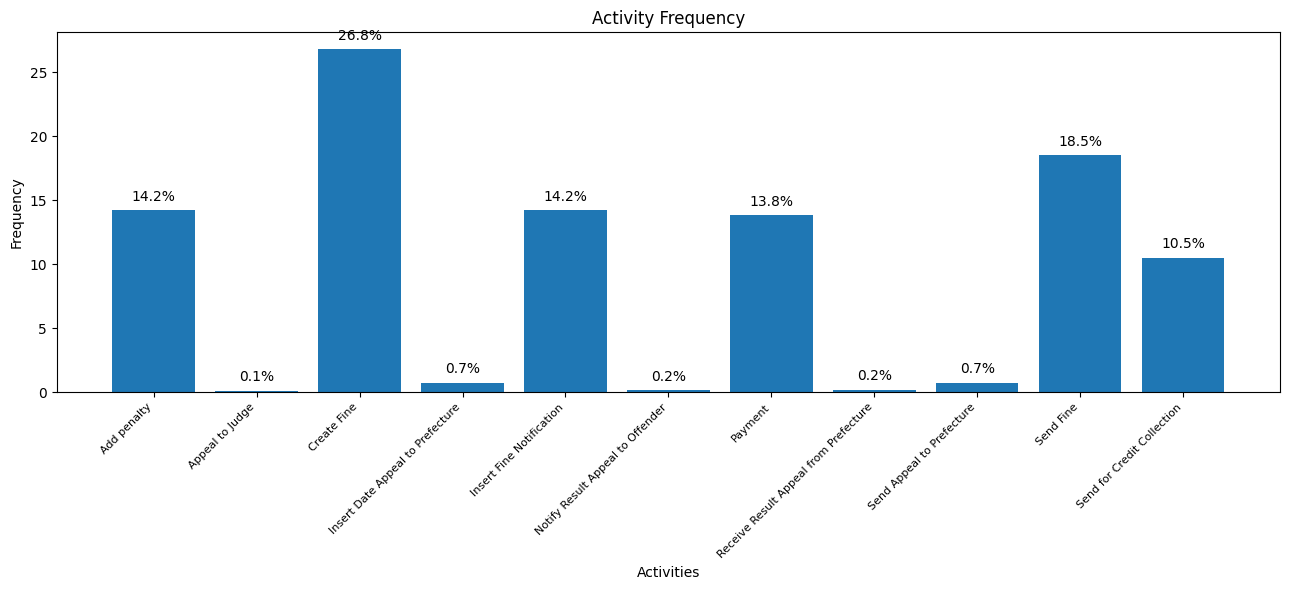

In [160]:
# Calculate category frequencies
category_frequencies = (df.groupby('concept:name').size() / len(df)) * 100

# Create a figure with a larger size
plt.figure(figsize=(13, 6))

# Plot the bar chart
plt.bar(category_frequencies.index, category_frequencies.values)

# Set x and y labels
plt.xlabel('Activities')
plt.ylabel('Frequency')
plt.title('Activity Frequency')

# Add text labels for each bar
for i, v in enumerate(category_frequencies.values):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

# Rotate x-axis labels and adjust font size
plt.xticks(rotation=45, ha='right', fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()

### Goals and Assignments for Road-Traffic Fines Case Study

#### Goal 1: Increase Payment Completion Probability

**Assignment Mapping:**
- **Filtering steps to remove noise:** Exclude incomplete or unclear fine cases where payment status is ambiguous or incomplete.
- **Filtering steps to remove irrelevant data:** Exclude cases not related to payment completion, such as cases dismissed or under appeal.
- **Filtering steps to summarize data:** Aggregate data to calculate payment completion rates over time and identify trends.
- **Segments of the log describing normal behavior:** Focus on cases where fines are paid promptly or within reasonable timeframes after notification.
- **Segments of the log describing anomalous behavior:** Identify cases where fines remain unpaid despite multiple notifications or cases that require escalated actions like credit collection.

#### Goal 2: Reduce Process Management Costs

**Assignment Mapping:**
- **Filtering steps to remove noise:** Exclude cases with administrative errors or incomplete data entries that could skew cost calculations.
- **Filtering steps to remove irrelevant data:** Exclude cases with minimal financial impact or those already resolved without significant management costs.
- **Filtering steps to summarize data:** Summarize data related to the cost of fine management, including operational expenses and resource utilization.
- **Segments of the log describing normal behavior:** Analyze cases where fines are managed efficiently with minimal administrative overhead.
- **Segments of the log describing anomalous behavior:** Identify cases where fine management incurs unexpectedly high costs due to delays, errors, or repeated notifications.

#### Goal 3: Early Detection of Process Issues

**Assignment Mapping:**
- **Filtering steps to remove noise:** Exclude cases with atypical or sporadic process events that do not represent typical fine management scenarios.
- **Filtering steps to remove irrelevant data:** Exclude cases with straightforward resolutions or those not indicative of potential process issues.
- **Filtering steps to summarize data:** Summarize data on process execution times, notification delays, and appeal outcomes.
- **Segments of the log describing normal behavior:** Focus on cases where fines progress smoothly through standard stages of notification, payment, or appeal.
- **Segments of the log describing anomalous behavior:** Identify cases with prolonged or abnormal durations between process stages, frequent appeals, or unresolved fines requiring escalated actions.

### Summary

Each goal in the case study on road-traffic fines has specific assignments related to filtering, summarizing, and analyzing event log data to achieve actionable insights:

- **Goal 1** focuses on improving payment completion rates.
- **Goal 2** aims to reduce the costs associated with managing fines.
- **Goal 3** targets early detection of process inefficiencies or abnormalities.

These assignments ensure that the event log data is effectively utilized to address the objectives of the study, leading to informed decisions and potential interventions in fine management processes.


# Applying filters and noise removal

the first filter is related to case duration.

In [162]:
num_events = len(df)
num_cases = len(df['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))

start_activities = pm4py.get_start_activities(df)
end_activities = pm4py.get_end_activities(df)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))


Number of events: 561470
Number of cases: 150370
Start activities: {'Create Fine': 150370}
End activities: {'Send Fine': 20755, 'Send for Credit Collection': 58997, 'Payment': 67201, 'Send Appeal to Prefecture': 3144, 'Appeal to Judge': 134, 'Notify Result Appeal to Offender': 86, 'Receive Result Appeal from Prefecture': 53}


In [163]:
# Activity with null time duration

## Get max duration
case_durations = pm4py.get_all_case_durations(df)
#print(case_durations)

## Alternative way using dataframe
case_durations = df.groupby('case:concept:name').agg(\
Events=('case:concept:name', 'count'),\
# Multiple aggregations of the same column using pandas ...
FirstOccurence=('time:timestamp', lambda x: x.min()),
LastOccurence=('time:timestamp', lambda x: x.max()),
Duration=('time:timestamp', lambda x: x.max() - x.min()),
)
#print(case_durations)

## Let's verify we have cases with duration 0
min_case_duration = case_durations['Duration'].min()
max_case_duration = case_durations['Duration'].max()
mean_case_duration = case_durations['Duration'].mean()

print("Min Case Duration: {}\nMax Case Duration: {}\nMean Case Duration: {}".format(min_case_duration, max_case_duration, mean_case_duration))


Min Case Duration: 0 days 00:00:00
Max Case Duration: 4372 days 00:00:00
Mean Case Duration: 341 days 16:06:01.029460664


In [164]:
df["dismissal"].unique()

array(['NIL', nan, '#', 'G', 'N', 'K', '5', '3', 'A', 'I', 'D', 'T', 'E',
       '@', 'M', 'Q', 'F', 'V', 'U', 'C', 'B', '$', 'Z', 'J', 'R', '2',
       '4'], dtype=object)

In [165]:
filtered_log = pm4py.filter_case_performance(df, 0, 0)
print("Given {} total cases in the log we have {} cases that comply with the applied filter".format(len(df['case:concept:name'].unique()), len(filtered_log['case:concept:name'].unique())))

## Let's verify they are all noise

variants = pm4py.get_variants(filtered_log)

print(variants) # Not all of them are noise, they incldue valid traces getting the end like ('Create Fine', 'Payment')

Given 150370 total cases in the log we have 4920 cases that comply with the applied filter
{('Create Fine', 'Payment'): 4802, ('Create Fine', 'Send Fine'): 118}


In [166]:
## Let's filter on cases with duration 0 and not ending with a Payment activity

filtered_log = pm4py.filter_variants(df, [('Create Fine', 'Send Fine')], retain=True)
filtered_log = pm4py.filter_case_performance(filtered_log, 0, 0)
variants = pm4py.get_variants(filtered_log)
print(variants)

{('Create Fine', 'Send Fine'): 118}


In [172]:
## Let's remove this log segment from the total event log 
### we use pandas functions to get the difference between data frames
### pm4py unfortunately offers very limited options for set operations with event logs 

#log_df_diff = log_df.compare(filtered_log) # working only if the dataframe have the same index
log_df = pd.concat([df,filtered_log]).drop_duplicates(keep=False)

num_events = len(log_df)
num_cases = len(log_df['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))


Number of events: 561234
Number of cases: 150252


In [173]:
def format_dismiss(row):
    if row['dismissal'] in ['#', 'G']:
        return True
    elif row['dismissal'] == 'NIL':
        return False
    elif pd.isna(row['dismissal']):
        return False
    else:
        return "Unknown"

log_df['dismissal'] = log_df.apply(format_dismiss, axis =1)

In [174]:
log_df['dismissal'].unique()

array([False, True, 'Unknown'], dtype=object)

In [175]:
unknown_dismissal = log_df[log_df['dismissal'].isin(['Unknown'])]['case:concept:name'].unique()
log_df = log_df[~log_df['case:concept:name'].isin(unknown_dismissal.tolist())]

In [176]:
log_df_ = log_df.fillna(0)

C:\Users\Robin_T480\AppData\Local\Temp\ipykernel_27100\3514559444.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  log_df_ = log_df.fillna(0)


In [177]:
def format_amounts (row):
    if row ['concept:name'] == 'Create Fine':
        return row['amount']
    elif row['concept:name'] == 'Send Fine':
        return row['expense']
    elif row['concept:name'] == 'Add penalty':
        return row['amount']
    elif row['concept:name'] == 'Payment':
        return row['paymentAmount']
    else:
        return 0
        
log_df["amount"] = log_df.apply (format_amounts ,axis =1)

In [178]:
# Incomplete cases

## Let's consider incomplete all cases not ending with a legal end activity like Payment or Send for Credit Collection

filtered_log = pm4py.filter_end_activities(df, ['Payment', 'Send for Credit Collection', 'Send Appeal to Prefecture', 'Appeal to Judge'])
                                           
print("Given {} total cases in the log we have {} cases that comply with the applied filter".format(len(df['case:concept:name'].unique()), len(filtered_log['case:concept:name'].unique())))
#print("The cycle time of the entire log is {} while the cycle time of the cases that comply with the applied filter is {}".format(cycle_time_log, cycle_time_filtered_log))


Given 150370 total cases in the log we have 129476 cases that comply with the applied filter


In [182]:
## Let's filter traces by attribute value
### we know 'Send Appeal to Prefecture' and 'Appeal to Judge' can be considered a legal end activity only if the value of the 'dismissal' attribute is equal to '#' or 'G' respectively 

filtered_log_att = pm4py.filter_end_activities(filtered_log, ['Send Appeal to Prefecture', 'Appeal to Judge'])
filtered_log_att = pm4py.filter_trace_attribute_values(filtered_log_att, 'dismissal', ['#', 'G'])

print("Given {} total cases in the log we have {} cases that comply with the applied filter".format(len(filtered_log['case:concept:name'].unique()), len(filtered_log_att['case:concept:name'].unique())))


Given 129476 total cases in the log we have 2039 cases that comply with the applied filter


In [183]:
## Let's merge the log segments we obtained 

filtered_log = pd.concat([filtered_log,filtered_log_att])

num_events = len(filtered_log)
num_cases = len(filtered_log['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))

Number of events: 530735
Number of cases: 129476


In [184]:
## let's compute case duration for the filtered log 

case_durations_f = filtered_log.groupby('case:concept:name').agg(\
Events=('case:concept:name', 'count'),\
# Multiple aggregations of the same column using pandas ...
FirstOccurence=('time:timestamp', lambda x: x.min()),
LastOccurence=('time:timestamp', lambda x: x.max()),
Duration=('time:timestamp', lambda x: x.max() - x.min()),
)

min_case_duration_f = case_durations_f['Duration'].min()
max_case_duration_f = case_durations_f['Duration'].max()
mean_case_duration_f = case_durations_f['Duration'].mean()

print("TOTAL event log \nMin Case Duration: {}\nMax Case Duration: {}\nMean Case Duration: {}".format(min_case_duration, max_case_duration, mean_case_duration))

print("FILTERED event log \nMin Case Duration: {}\nMax Case Duration: {}\nMean Case Duration: {}".format(min_case_duration_f, max_case_duration_f, mean_case_duration_f))


TOTAL event log 
Min Case Duration: 0 days 00:00:00
Max Case Duration: 4372 days 00:00:00
Mean Case Duration: 341 days 16:06:01.029460664
FILTERED event log 
Min Case Duration: 0 days 00:00:00
Max Case Duration: 4372 days 00:00:00
Mean Case Duration: 381 days 01:59:18.849516512


## Summarizing 


In [57]:
filtered_log

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
2,35.0,561,False,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,False,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN
4,NaN,NaN,False,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN
5,71.5,NaN,False,Add penalty,NaN,NaN,complete,2007-03-16 00:00:00+00:00,NaN,NaN,A100,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,False,Send for Credit Collection,NaN,NaN,complete,2009-03-30 00:00:00+00:00,NaN,NaN,A100,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560921,NaN,NaN,False,Send Fine,NaN,NaN,complete,2002-10-25 00:00:00+00:00,NaN,NaN,V9791,10.0,NaN,NaN,NaN,NaN
560922,NaN,NaN,False,Insert Fine Notification,NaN,NaN,complete,2002-10-31 00:00:00+00:00,NaN,NaN,V9791,NaN,P,N,NaN,NaN
560923,NaN,NaN,False,Insert Date Appeal to Prefecture,NaN,NaN,complete,2002-12-12 00:00:00+00:00,NaN,NaN,V9791,NaN,NaN,NaN,NaN,NaN
560924,262.0,NaN,False,Add penalty,NaN,NaN,complete,2002-12-30 00:00:00+00:00,NaN,NaN,V9791,NaN,NaN,NaN,NaN,NaN


In [185]:
pd.set_option('display.max_colwidth', None)

In [186]:
## Let's get the variants of the filtered log

variants = pm4py.get_variants(filtered_log)
variants_df = pd.DataFrame.from_dict(variants, orient='index', columns=['Count'])
# create a new column with index values
#variants_df['Variant'] = variants_df.index
variants_df = variants_df.reset_index()
variants_df = variants_df.rename(columns={'index': 'Variant'})
variants_df = variants_df.sort_values(by=['Count'], ascending=False)
variants_df = variants_df.reset_index(drop=True)
variants_df

,Variant,Count
0,"(Create Fine, Send Fine, Insert Fine Notification, Add penalty, Send for Credit Collection)",56482
1,"(Create Fine, Payment)",46371
2,"(Create Fine, Send Fine, Insert Fine Notification, Add penalty, Payment)",9520
3,"(Create Fine, Send Fine, Insert Fine Notification, Add penalty, Payment, Payment)",3736
4,"(Create Fine, Send Fine, Insert Fine Notification, Payment, Add penalty, Payment)",3301
...,...,...
310,"(Create Fine, Send Fine, Insert Fine Notification, Add penalty, Appeal to Judge, Create Fine, Send Fine, Insert Fine Notification, Payment, Add penalty)",1
311,"(Create Fine, Payment, Payment, Send Fine, Insert Fine Notification, Add penalty, Payment)",1
312,"(Create Fine, Send Fine, Insert Fine Notification, Insert Date Appeal to Prefecture, Send Appeal to Prefecture, Receive Result Appeal from Prefecture, Add penalty, Notify Result Appeal to Offender, Appeal to Judge, Create Fine, Payment, Create Fine, Send Fine, Insert Fine Notification, Add penalty, Payment, Payment, Create Fine)",1
313,"(Create Fine, Send Fine, Insert Fine Notification, Add penalty, Insert Date Appeal to Prefecture, Appeal to Judge, Send Appeal to Prefecture)",1


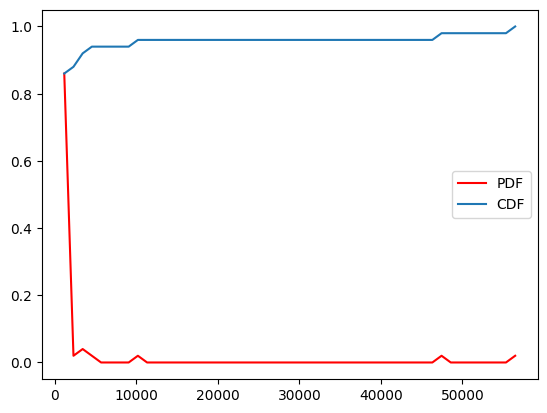

In [187]:
## Let's plot the PDF 

# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
  
data= variants_df['Count'].head(50)

# getting data of the histogram
count, bins_count = np.histogram(data, bins=50)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()

In [188]:
## Let's extract the top k variants
# Perform an exploratory analysis to understand the distribution of variants
variant_counts = pm4py.get_variants(log)
sorted_variant_counts = sorted(variant_counts.items(), key=lambda item: item[1], reverse=True)

# Calculate cumulative coverage
cumulative_count = 0
total_cases = len(log)
cumulative_coverage = []
for variant, count in sorted_variant_counts:
    cumulative_count += count
    cumulative_coverage.append(cumulative_count / total_cases)

# Choose `k` based on desired coverage (e.g., 80%)
desired_coverage = 0.8
k = len(cumulative_coverage)  # Fallback value to include all variants if desired coverage isn't met

for i, coverage in enumerate(cumulative_coverage):
    if coverage >= desired_coverage:
        k = i + 1
        break

print("Chosen K:", k)

# Filter the log to retain only the top `k` variants
filtered_log = pm4py.filter_variants_top_k(filtered_log, 10)

# Now `filtered_log` contains only the top `k` most frequent variants


num_events = len(filtered_log)
num_cases = len(filtered_log['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))


Chosen K: 231
Number of events: 491845
Number of cases: 125454


In [61]:
# filtered_log = pm4py.filter_case_performance(log, 60, 18144000)

number of cases:  125454


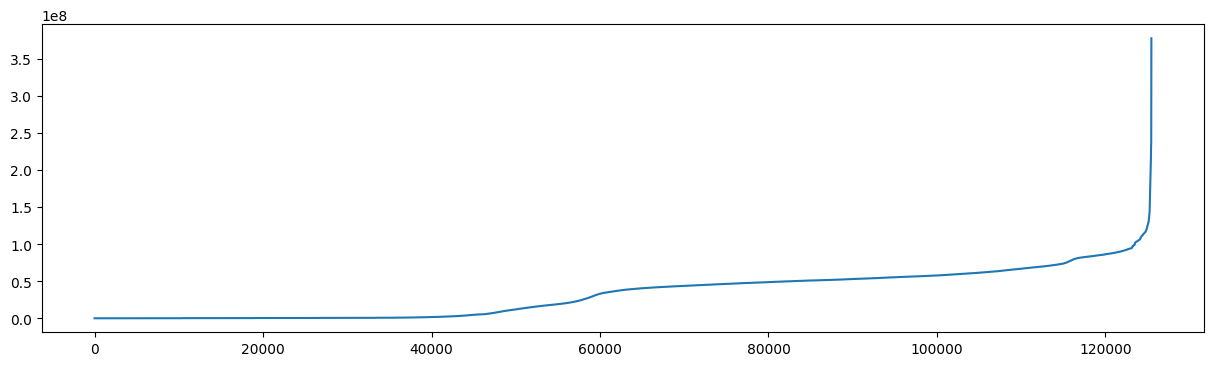

In [189]:
durations = pm4py.get_all_case_durations(filtered_log)
print("number of cases: ",len(durations))
x_values = range(len(durations))
plt.figure(figsize=(15, 4))
plt.plot(x_values, durations)
plt.show()

The second filter is top-k variant

In [190]:
print("remaining cases:",len(pm4py.get_all_case_durations(filtered_log)))

remaining cases: 125454


In [49]:
# filtered_log = pm4py.filter_start_activities(filtered_log,["Create Fine"])


# # a dynamic strategy to filter the log_ends
# # Step 1: Sort the values in descending order
# sorted_values = sorted(log_end.values(), reverse=True)

# # Step 2: Choose a percentage threshold (e.g., 90%)
# percentage_threshold = 90

# # Step 3: Calculate the index that corresponds to the threshold
# threshold_index = int(len(sorted_values) * (percentage_threshold / 100))

# # Step 4: Get the threshold value
# threshold_value = sorted_values[threshold_index - 1] if threshold_index > 0 else 0

# # Step 5: Filter the keys based on the threshold value
# filtered_log_end = [key for key, value in log_end.items() if value >= threshold_value]

# print("Percentage threshold:", percentage_threshold)
# print("Threshold value:", threshold_value)
# print("Filtered keys:", filtered_log_end)
# filtered_log = pm4py.filter_end_activities(filtered_log, filtered_log_end)

# print("remaining cases:",len(pm4py.get_all_case_durations(filtered_log)))

the next filter is based on activity repetition. for example it is not meaningfull for a case, we have multiple delete invoice.

In [195]:
cases_to_exclude = pd.concat([
    pm4py.filter_activities_rework(filtered_log, "Send Fine", 2),
    pm4py.filter_activities_rework(filtered_log, "Send for Credit Collection'", 2)
    ])
cases_to_exclude = cases_to_exclude["case:concept:name"].unique()

print("cases to exclude:",len(cases_to_exclude))
print("total cases:", len(filtered_log["case:concept:name"].unique()))
filtered_log = filtered_log[~filtered_log['case:concept:name'].isin(cases_to_exclude)]
print("total cases:", len(filtered_log["case:concept:name"].unique()))

cases to exclude: 0
total cases: 125454
total cases: 125454


C:\Users\Robin_T480\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Robin_T480\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Robin_T480\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Robin_T480\AppData\Local\Programs\Python\Python311\Lib\site-p

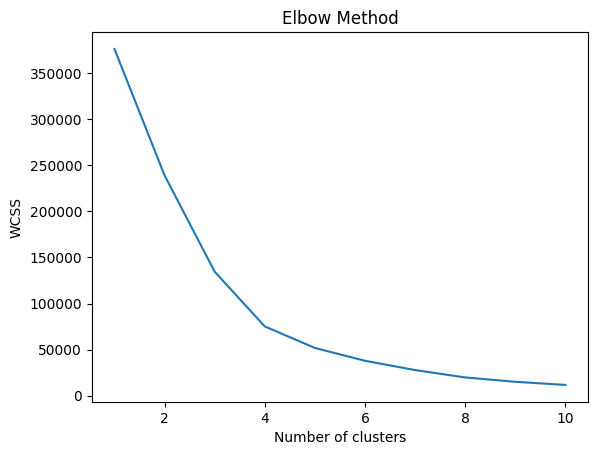

In [192]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



# Feature engineering: create a case-level feature matrix
case_features = filtered_log.groupby('case:concept:name').agg({
    'amount': 'sum',
    'points': 'sum',
    'concept:name': 'count'  # Number of events
}).reset_index()

# Renaming columns for clarity
case_features.rename(columns={
    'amount': 'total_amount',
    'points': 'total_points',
    'concept:name': 'num_events'
}, inplace=True)

# Normalizing the features
scaler = StandardScaler()
case_features[['total_amount', 'total_points', 'num_events']] = scaler.fit_transform(case_features[['total_amount', 'total_points', 'num_events']])

# Determine the optimal number of clusters (K)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(case_features[['total_amount', 'total_points', 'num_events']])
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

C:\Users\Robin_T480\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0:
       total_amount  total_points    num_events  cluster
count  73060.000000  73060.000000  73060.000000  73060.0
mean       0.184367     -0.128667      0.791913      0.0
std        0.703959      0.006855      0.222709      0.0
min       -0.685831     -0.128693     -1.255351      0.0
25%       -0.036167     -0.128693      0.705603      0.0
50%        0.023802     -0.128693      0.705603      0.0
75%        0.083771     -0.128693      0.705603      0.0
max        7.283388      1.724287      1.359254      0.0
Cluster 1:
       total_amount  total_points    num_events  cluster
count  49483.000000  49483.000000  49483.000000  49483.0
mean      -0.434026     -0.128693     -1.214163      1.0
std        0.097348      0.000000      0.158828      0.0
min       -0.685831     -0.128693     -1.255351      1.0
25%       -0.461947     -0.128693     -1.255351      1.0
50%       -0.452618     -0.128693     -1.255351      1.0
75%       -0.432629     -0.128693     -1.255351      1.0
max      

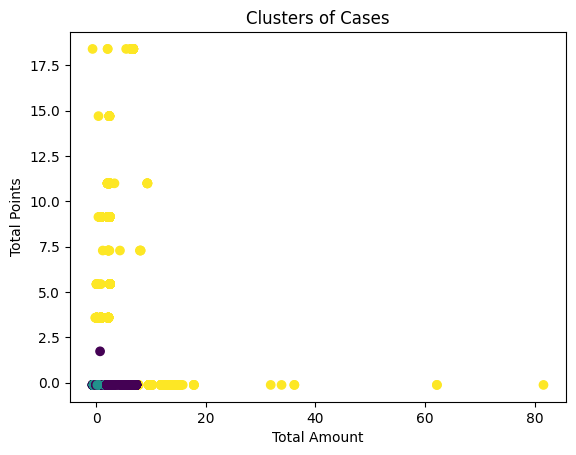

In [194]:
# Applying K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=42) 
case_features['cluster'] = kmeans.fit_predict(case_features[['total_amount', 'total_points', 'num_events']])

# Analyzing the clusters
for i in range(3):  
    print(f"Cluster {i}:")
    print(case_features[case_features['cluster'] == i].describe())

# Visualizing the clusters
plt.scatter(case_features['total_amount'], case_features['total_points'], c=case_features['cluster'], cmap='viridis')
plt.title('Clusters of Cases')
plt.xlabel('Total Amount')
plt.ylabel('Total Points')
plt.show()

## Cluster Analysis of `case_features` with 4 Clusters

### Cluster 0:
- **Size (count):** 49,500 cases
- **Characteristics:**
  - **total_amount:** Mean around -0.43, with a standard deviation of 0.10. Ranges from -0.68 to 2.67.
  - **total_points:** Mean around -0.13, with a standard deviation of 0.03. Ranges are relatively tight.
  - **num_events:** Mean around -1.20, indicating fewer events compared to other clusters. Standard deviation is moderate.
- **Interpretation:** Cluster 0 represents cases with relatively low total amounts and points, and fewer total events. These cases are likely simpler or less complex compared to other clusters.

### Cluster 1:
- **Size (count):** 75,864 cases
- **Characteristics:**
  - **total_amount:** Mean around 0.15, with a wider spread (std=0.50). Ranges from -0.68 to 4.68.
  - **total_points:** Mean around -0.06, with a larger spread (std=0.51). Ranges vary significantly.
  - **num_events:** Mean around 0.76, indicating a moderate number of events. Standard deviation suggests variability.
- **Interpretation:** Cluster 1 represents cases with moderate total amounts and points, and a moderate number of events. This cluster likely includes a variety of cases with medium complexity.

### Cluster 2:
- **Size (count):** 786 cases
- **Characteristics:**
  - **total_amount:** Mean around 9.23, with a standard deviation of 5.32. Ranges are from 4.90 to 79.56.
  - **total_points:** Mean around -0.13, with a very small standard deviation (almost zero). Values are tightly grouped.
  - **num_events:** Mean around 0.79, indicating a moderate number of events. Standard deviation suggests some variability.
- **Interpretation:** Cluster 2 represents cases with significantly higher total amounts compared to other clusters, but similar total points and moderate event counts. These cases might involve larger fines or more complex financial situations.

### Cluster 3:
- **Size (count):** 1,232 cases
- **Characteristics:**
  - **total_amount:** Mean around 2.21, with a standard deviation of 1.23. Ranges from -0.68 to 9.07.
  - **total_points:** Mean around 8.99, with a standard deviation of 2.34. Values vary notably.
  - **num_events:** Mean around 0.86, indicating a moderate number of events. Standard deviation suggests variability.
- **Interpretation:** Cluster 3 represents cases with moderate total amounts, higher total points, and a moderate number of events. These cases might involve more severe violations or more complicated legal processes.

---

### Summary
- **Cluster 0:** Simple cases with lower total amounts, points, and fewer events.
- **Cluster 1:** Moderate cases with varied amounts, points, and a moderate number of events.
- **Cluster 2:** Complex cases with significantly higher total amounts and moderate event counts.
- **Cluster 3:** Cases with moderate amounts, higher points, and a moderate number of events, possibly indicating more severe or complex violations.

### Practical Use
Understanding these clusters helps in categorizing cases based on their financial implications, severity of violations, and process complexity. This clustering can guide decisions on resource allocation, intervention strategies, or further detailed analysis tailored to each cluster's characteristics.


# Process Discovery

In [41]:
# ! dot -version

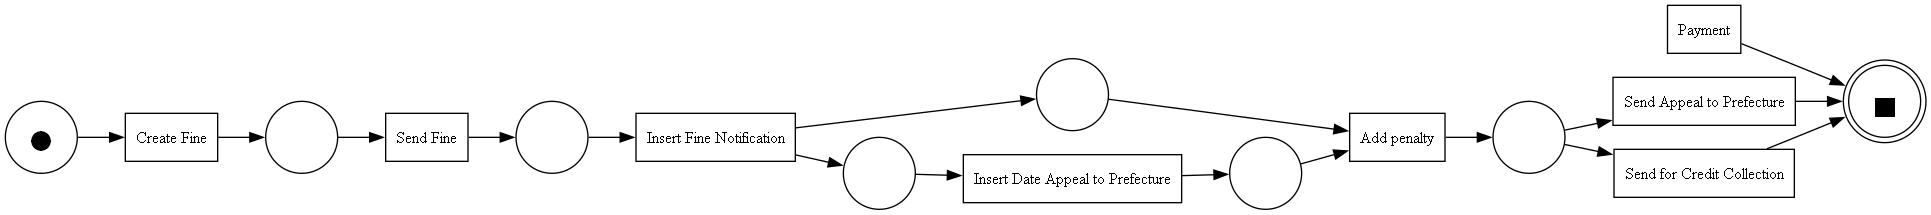

In [196]:
#alpha miner
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(filtered_log)
pm4py.view_petri_net(net, initial_marking, final_marking)

In [197]:
# fitness for alpha miner:
print("replay based fitness:",pm4py.fitness_token_based_replay(filtered_log, net, initial_marking, final_marking))
print("replay based precision:",pm4py.precision_token_based_replay(filtered_log, net, initial_marking, final_marking))
print("generalization:",generalization_evaluator.apply(filtered_log, net, initial_marking, final_marking))
print("simplicity:",simplicity_evaluator.apply(net))

replaying log with TBR, completed traces :: 100%|████████████████████████████████████████| 9/9 [00:01<00:00,  4.80it/s]


replay based fitness: {'perc_fit_traces': 0.6982639054952413, 'average_trace_fitness': 0.8354134213112436, 'log_fitness': 0.8309338322219397, 'percentage_of_fitting_traces': 0.6982639054952413}


replaying log with TBR, completed traces :: 100%|██████████████████████████████████████| 9/9 [00:00<00:00, 4443.12it/s]


replay based precision: 0.67744527826278


replaying log with TBR, completed traces :: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 10.37it/s]


generalization: 0.9888759824824958
simplicity: 0.8888888888888888


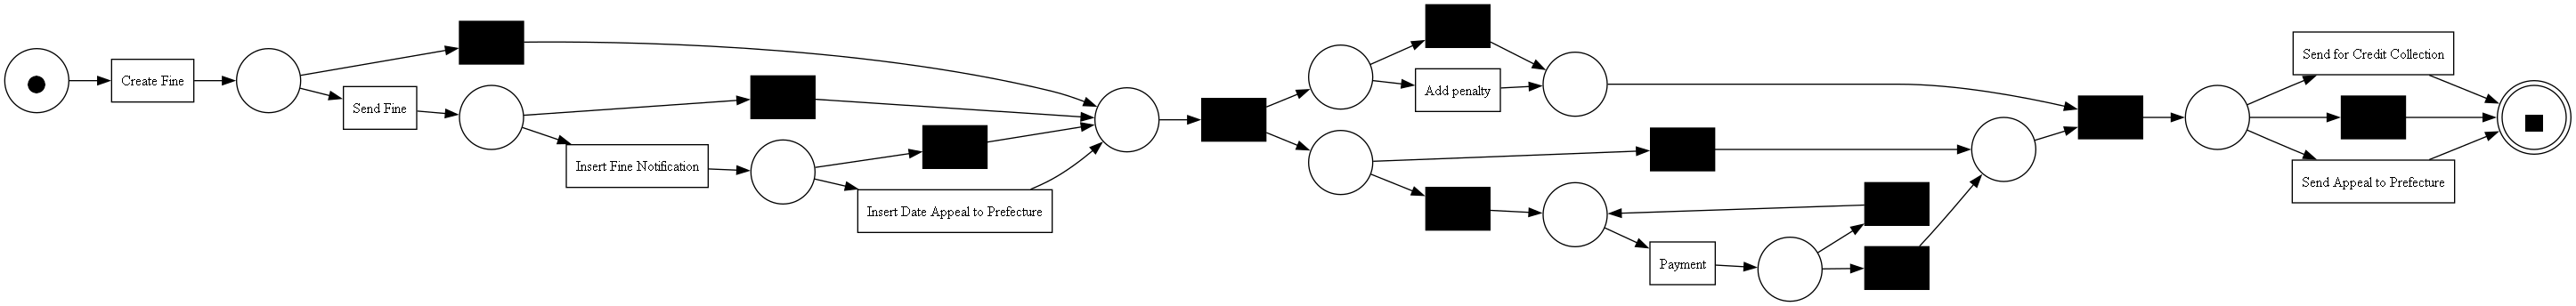

In [198]:
# inductive minder:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(filtered_log)
pm4py.view_petri_net(net, initial_marking, final_marking)

In [199]:
# fitness for inductive miner:
print("replay based fitness:",pm4py.fitness_token_based_replay(filtered_log, net, initial_marking, final_marking))
print("replay based precision:",pm4py.precision_token_based_replay(filtered_log, net, initial_marking, final_marking))
print("generalization:",generalization_evaluator.apply(filtered_log, net, initial_marking, final_marking))
print("simplicity:",simplicity_evaluator.apply(net))

replaying log with TBR, completed traces :: 100%|████████████████████████████████████████| 9/9 [00:01<00:00,  6.62it/s]


replay based fitness: {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed traces :: 100%|████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]


replay based precision: 0.6004576446831842


replaying log with TBR, completed traces :: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 11.95it/s]


generalization: 0.9919500285557509
simplicity: 0.6666666666666666


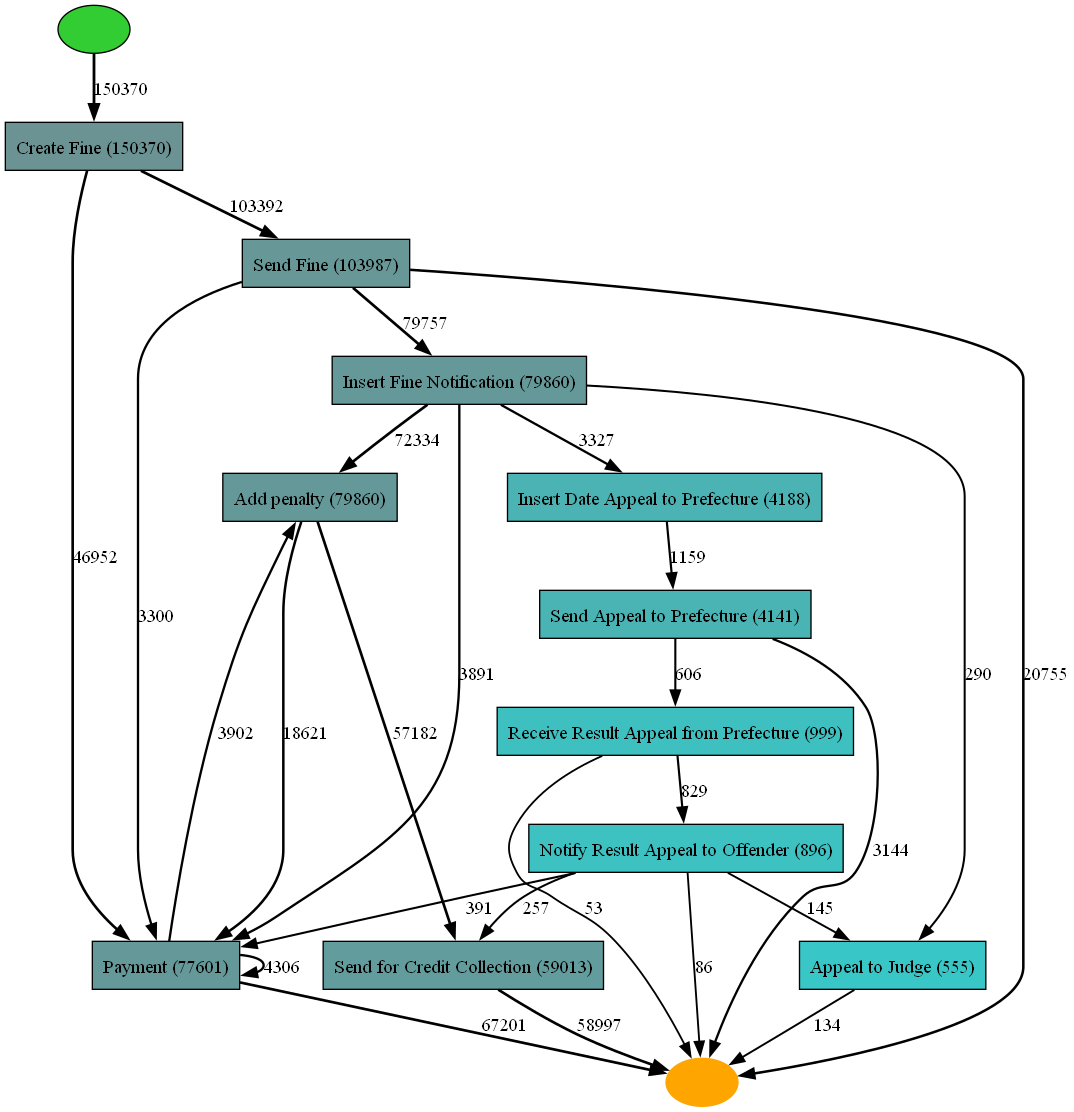

In [200]:
#Huristic miner
heu_net = pm4py.discover_heuristics_net(log, dependency_threshold=0.99,and_threshold = 0.99,loop_two_threshold=0.99)
pm4py.view_heuristics_net(heu_net)

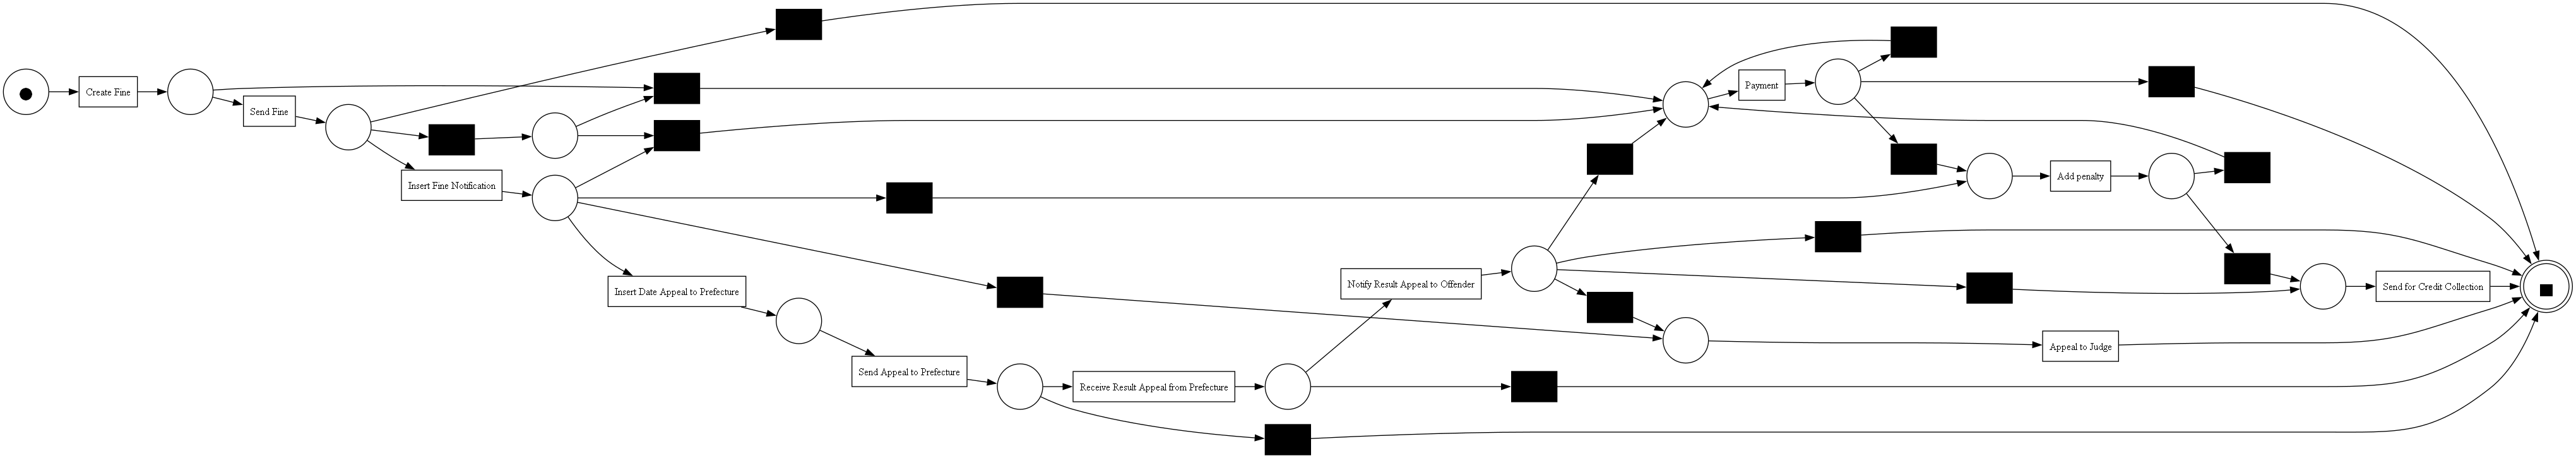

In [201]:
#Petri-net of huristic miner:
net, im, fm = pm4py.discover_petri_net_heuristics(log, dependency_threshold=0.99,and_threshold = 0.99,loop_two_threshold=0.99)
pm4py.view_petri_net(net, im, fm)

In [202]:
# fitness for huristic miner:
print("replay based fitness:",pm4py.fitness_token_based_replay(filtered_log, net, initial_marking, final_marking))
print("replay based precision:",pm4py.precision_token_based_replay(filtered_log, net, initial_marking, final_marking))
print("generalization:",generalization_evaluator.apply(filtered_log, net, initial_marking, final_marking))
print("simplicity:",simplicity_evaluator.apply(net))

replaying log with TBR, completed traces :: 100%|████████████████████████████████████████| 9/9 [00:01<00:00,  6.26it/s]


replay based fitness: {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.46074208949289197, 'log_fitness': 0.604007655769335, 'percentage_of_fitting_traces': 0.0}


replaying log with TBR, completed traces :: 100%|██████████████████████████████████████| 9/9 [00:00<00:00, 4512.16it/s]


replay based precision: 1.0


replaying log with TBR, completed traces :: 100%|████████████████████████████████████████| 9/9 [00:02<00:00,  4.26it/s]


generalization: 0.45933925857280344
simplicity: 0.6111111111111112


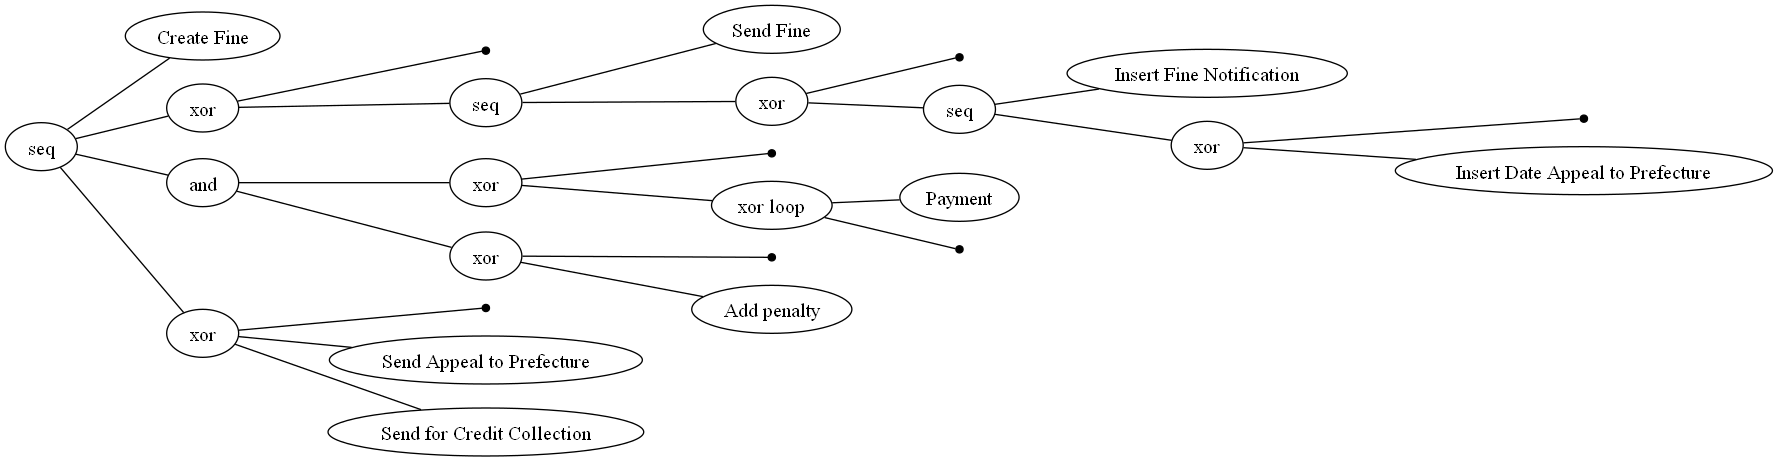

In [49]:
# process tree
tree = pm4py.discover_process_tree_inductive(filtered_log)
pm4py.view_process_tree(tree)

## Conformance checking diagnostic

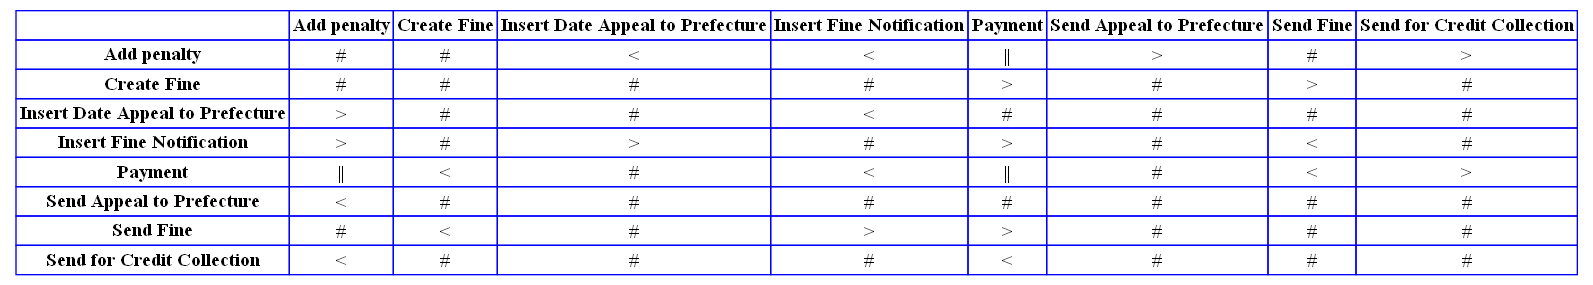

In [250]:
footprints = pm4py.discover_footprints(filtered_log)
pm4py.view_footprints(footprints, format='png')

In [203]:
## Define optional parameters
opt_parameters = {'return_object_names': True}

tbr_diagnostics = pm4py.conformance_diagnostics_token_based_replay(filtered_log, net, im, fm, return_diagnostics_dataframe=True)
# Using the parameter return_diagnostics_dataframe we can obtain diagnostics in DF format and this provide us with case_id
tbr_diagnostics

replaying log with TBR, completed traces :: 100%|████████████████████████████████████████| 9/9 [00:02<00:00,  4.49it/s]


,case_id,is_fit,trace_fitness,missing,remaining,produced,consumed
0,A100,True,1.000000,0,0,8,8
1,A10000,True,1.000000,0,0,9,9
2,A10004,True,1.000000,0,0,8,8
3,A10005,False,0.750000,1,1,4,4
4,A10007,False,0.750000,1,1,4,4
...,...,...,...,...,...,...,...
125449,V9995,True,1.000000,0,0,8,8
125450,V9996,False,0.833333,1,1,6,6
125451,V9997,True,1.000000,0,0,8,8
125452,V9998,True,1.000000,0,0,8,8


In [204]:
# Filter disfunctional cases

## Get the Case_ID of the cases with low fitness values
disfuntional_traces = tbr_diagnostics['case_id'][tbr_diagnostics['trace_fitness'] <= 0.74].tolist()

print(disfuntional_traces)

## Apply a filter to remove the list of disfunctional cases
filtered_dataframe = pm4py.filter_event_attribute_values(filtered_log, 'case:concept:name', disfuntional_traces, retain=False)


[]


In [205]:
# Conformance checking diagnostic OLD VERSION
tbr_diagnostics = pm4py.conformance_diagnostics_token_based_replay(filtered_log, net, im, fm)
diagnostics_df = pd.DataFrame.from_dict(tbr_diagnostics)

diagnostics_df

print(diagnostics_df)

# Get the idnexes of the cases with low fitness values

disfuntional_traces = diagnostics_df.index[diagnostics_df['trace_fitness'] <= 0.7].tolist()

print(disfuntional_traces)

# Filter those cases from the event log
##  add prefix to index value in the list
prefix = 'patient'
disfuntional_traces_rename = [prefix + str(x) for x in disfuntional_traces]

disfuntional_traces_rename

## apply a filter to remove the list of disfunctional cases
#filtered_dataframe = pm4py.filter_event_attribute_values(log_csv, 'case:concept:name', disfuntional_traces_rename, case_id_key='case:concept:name')


replaying log with TBR, completed traces :: 100%|████████████████████████████████████████| 9/9 [00:01<00:00,  5.08it/s]


        trace_is_fit  trace_fitness  \
0               True       1.000000   
1               True       1.000000   
2               True       1.000000   
3              False       0.750000   
4              False       0.750000   
...              ...            ...   
125449          True       1.000000   
125450         False       0.833333   
125451          True       1.000000   
125452          True       1.000000   
125453          True       1.000000   

                                                                                                                                                                                                                             activated_transitions  \
0       [(Create Fine, 'Create Fine'), (Send Fine, 'Send Fine'), (Insert Fine Notification, 'Insert Fine Notification'), (hid_22, None), (Add penalty, 'Add penalty'), (hid_13, None), (Send for Credit Collection, 'Send for Credit Collection')]   
1                             [(Create 

[]

In [206]:
# Conformance checking diagnostic
## Using Aligments DF provides case_id but less attributes
al_diagnostics = pm4py.conformance_diagnostics_alignments(filtered_log, net, im, fm, return_diagnostics_dataframe=True)

## Let's create another DF from the dictioanry
al_diagnostics_dic = pm4py.conformance_diagnostics_alignments(filtered_log, net, im, fm)
diagnostics_ex = pd.DataFrame.from_dict(al_diagnostics_dic)

## Let's merge the two DFs
merged_df = pd.merge(al_diagnostics, diagnostics_ex, left_index=True, right_index=True)
# Alternatively, you can use the join() function
# merged_df = df1.join(df2)

merged_df

aligning log, completed variants :: 100%|███████████████████████████████████████████████| 9/9 [00:00<00:00, 118.65it/s]


,case_id,cost_x,fitness_x,is_fit,alignment,cost_y,visited_states,queued_states,traversed_arcs,lp_solved,fitness_y,bwc
0,A100,2,1.0,True,"[(Create Fine, Create Fine), (Send Fine, Send Fine), (Insert Fine Notification, Insert Fine Notification), (>>, None), (Add penalty, Add penalty), (>>, None), (Send for Credit Collection, Send for Credit Collection)]",2,7,24,24,3,1.0,70001
1,A10000,3,1.0,True,"[(Create Fine, Create Fine), (Send Fine, Send Fine), (Insert Fine Notification, Insert Fine Notification), (>>, None), (Add penalty, Add penalty), (>>, None), (Payment, Payment), (>>, None)]",3,8,27,27,3,1.0,70001
2,A10004,2,1.0,True,"[(Create Fine, Create Fine), (Send Fine, Send Fine), (Insert Fine Notification, Insert Fine Notification), (>>, None), (Add penalty, Add penalty), (>>, None), (Send for Credit Collection, Send for Credit Collection)]",2,7,24,24,3,1.0,70001
3,A10005,20001,0.5,False,"[(Create Fine, Create Fine), (>>, Send Fine), (Payment, >>), (>>, None)]",20001,5,13,13,7,0.5,40001
4,A10007,20001,0.5,False,"[(Create Fine, Create Fine), (>>, Send Fine), (Payment, >>), (>>, None)]",20001,5,13,13,7,0.5,40001
...,...,...,...,...,...,...,...,...,...,...,...,...
125449,V9995,2,1.0,True,"[(Create Fine, Create Fine), (Send Fine, Send Fine), (Insert Fine Notification, Insert Fine Notification), (>>, None), (Add penalty, Add penalty), (>>, None), (Send for Credit Collection, Send for Credit Collection)]",2,7,24,24,3,1.0,70001
125450,V9996,10001,0.8,False,"[(Create Fine, Create Fine), (Send Fine, Send Fine), (Payment, >>), (>>, None)]",10001,5,14,14,8,0.8,50001
125451,V9997,2,1.0,True,"[(Create Fine, Create Fine), (Send Fine, Send Fine), (Insert Fine Notification, Insert Fine Notification), (>>, None), (Add penalty, Add penalty), (>>, None), (Send for Credit Collection, Send for Credit Collection)]",2,7,24,24,3,1.0,70001
125452,V9998,2,1.0,True,"[(Create Fine, Create Fine), (Send Fine, Send Fine), (Insert Fine Notification, Insert Fine Notification), (>>, None), (Add penalty, Add penalty), (>>, None), (Send for Credit Collection, Send for Credit Collection)]",2,7,24,24,3,1.0,70001


In [207]:
merged_df['alignment']
print(type(merged_df['alignment'][0]))
print(merged_df['alignment'])

# Define data

data = merged_df['alignment']

<class 'list'>
0         [(Create Fine, Create Fine), (Send Fine, Send Fine), (Insert Fine Notification, Insert Fine Notification), (>>, None), (Add penalty, Add penalty), (>>, None), (Send for Credit Collection, Send for Credit Collection)]
1                                   [(Create Fine, Create Fine), (Send Fine, Send Fine), (Insert Fine Notification, Insert Fine Notification), (>>, None), (Add penalty, Add penalty), (>>, None), (Payment, Payment), (>>, None)]
2         [(Create Fine, Create Fine), (Send Fine, Send Fine), (Insert Fine Notification, Insert Fine Notification), (>>, None), (Add penalty, Add penalty), (>>, None), (Send for Credit Collection, Send for Credit Collection)]
3                                                                                                                                                         [(Create Fine, Create Fine), (>>, Send Fine), (Payment, >>), (>>, None)]
4                                                                            

In [208]:
# Indentify the indexes wtih different values
## Define the special case value
special_value = (">>", None)

## List to store indices of lists containing tuples with different values
contains_different_values_indices = []



# Iterate over each list in the Series
for idx, tuples_list in data.items():
    contains_different_values = False

    # Iterate over each tuple in the list
    for tup in tuples_list:
        # Check if the tuple is equal to the special case value
        if tup == special_value:
            continue  # Skip this tuple

        # Check if the tuple contains different values
        if tup[0] != tup[1]:
            contains_different_values = True
            break

    # If any tuple in the list contains different values, add its index to the result
    if contains_different_values:
        contains_different_values_indices.append(idx)

# Print the indices of lists containing tuples with different values
# print("Indices of lists containing tuples with different values:", contains_different_values_indices)


In [209]:
# Indentify the indexes wtih different values 2
# Assuming 'data' is your pandas Series and 'contains_different_values_indices' contains the indices of lists containing tuples with different values
# Define the special case value
special_value = (">>", None)

# Dictionary to store tuples with different values for each list
different_values_dict = {}

# Iterate over each index in contains_different_values_indices
for idx in contains_different_values_indices:
    tuples_list = data[idx]
    different_values = []

    # Iterate over each tuple in the list
    for tup in tuples_list:
        # Check if the tuple is equal to the special case value
        if tup == special_value:
            continue  # Skip this tuple

        # Check if the tuple contains different values
        if tup[0] != tup[1]:
            different_values.append(tup)

    # Save the list of tuples with different values for the current index
    different_values_dict[idx] = different_values

# Print the dictionary containing tuples with different values for each list
# print("Tuples with different values for each list:")
# for idx, different_values in different_values_dict.items():
#     print(f"Index {idx}: {different_values}")

In [210]:
# Assuming 'data' is your pandas Series and 'contains_different_values_indices' contains the indices of lists containing tuples with different values
# Define the special case value
special_value = (">>", None)

# Dictionary to store tuples with different values and their related tuples
related_tuples_dict = {}

# Iterate over each index in contains_different_values_indices
for idx in contains_different_values_indices:
    tuples_list = data[idx]

    # List to store tuples with different values for the current index
    different_values = []
    # Dictionary to store related tuples for the current index
    related_tuples = {}

    # Iterate over each tuple in the list
    for i, tup in enumerate(tuples_list):
        # Check if the tuple is equal to the special case value
        if tup == special_value:
            continue  # Skip this tuple

        # Check if the tuple contains different values
        if tup[0] != tup[1]:
            different_values.append(tup)

        # Check for related tuples
        for j in range(i + 1, len(tuples_list)):
            # Check if the second value of the current tuple matches the first value of a tuple with different values
            if tuples_list[j][0] == tup[1] and tuples_list[j][1] != tup[1]:
                related_tuples[tup] = tuples_list[j]
            # Check if the first value of the current tuple matches the second value of a tuple with different values
            elif tuples_list[j][1] == tup[0] and tuples_list[j][0] != tup[0]:
                related_tuples[tup] = tuples_list[j]

    # Save the list of tuples with different values and their related tuples for the current index
    related_tuples_dict[idx] = {"different_values": different_values, "related_tuples": related_tuples}

# Print the dictionary containing tuples with different values and their related tuples for each list
# print("Tuples with different values and their related tuples for each list:")
# for idx, values_dict in related_tuples_dict.items():
#     print(f"Index {idx}:")
#     print("Tuples with different values:", values_dict["different_values"])
#     print("Related tuples:", values_dict["related_tuples"])


to understand perfomances for each algoirthm we use heatmap to compare their results.

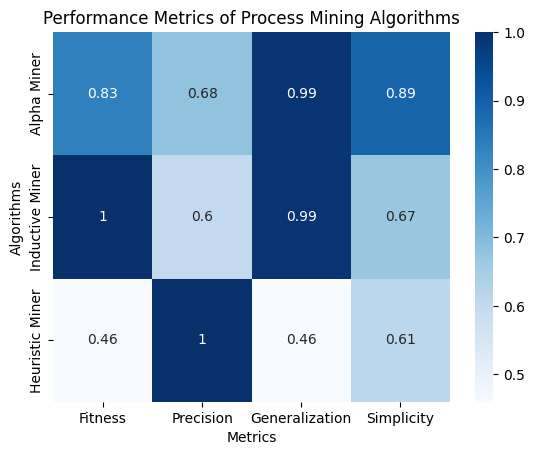

In [226]:
data = {'Algorithm': ['Alpha Miner', 'Inductive Miner', 'Heuristic Miner'],
        'Fitness': [0.835, 1.0, 0.46],
        'Precision': [0.68, 0.60, 1.0],
        'Generalization': [0.99, 0.99, 0.46],
        'Simplicity': [0.89, 0.67, 0.61]}
chart_dataframe = pd.DataFrame(data)
chart_dataframe.set_index('Algorithm', inplace=True)
sns.heatmap(chart_dataframe, annot=True, cmap='Blues')
plt.title('Performance Metrics of Process Mining Algorithms')
plt.xlabel('Metrics')
plt.ylabel('Algorithms')
plt.show()

In [215]:
len(filtered_log)

0

## Process tree

In [216]:
filtered_log = pm4py.filter_variants(log_df, [('Create Fine', 'Send Fine')], retain=True)
filtered_log = pm4py.filter_case_performance(filtered_log, 0, 0)
variants = pm4py.get_variants(filtered_log)
print(variants)

## Let's remove this log segment from the total event log 
### we use pandas functions to get the difference between data frames
### pm4py unfortunately offers very limited options for set operations with event logs 

#log_df_diff = log_df.compare(filtered_log) # working only if the dataframe have the same index
log_df = pd.concat([log_df,filtered_log]).drop_duplicates(keep=False)

num_events = len(log_df)
num_cases = len(log_df['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))


{}
Number of events: 560169
Number of cases: 149751



## Incomplete cases


In [217]:
## Let's consider incomplete all cases not ending with a legal end activity like Payment or Send for Credit Collection

filtered_log = pm4py.filter_end_activities(log_df, ['Payment', 'Send for Credit Collection', 'Send Appeal to Prefecture', 'Appeal to Judge'])

## Let's filter traces by attribute value
### we know 'Send Appeal to Prefecture' and 'Appeal to Judge' can be considered a legal end activity only if the value of the 'dismissal' attribute is equal to '#' or 'G' respectively 

filtered_log_att = pm4py.filter_end_activities(log_df, ['Send Appeal to Prefecture', 'Appeal to Judge'])
filtered_log_att = pm4py.filter_trace_attribute_values(filtered_log_att, 'dismissal', ['#', 'G'])

print("Given {} total cases in the log we have {} cases that comply with the applied filter".format(len(filtered_log['case:concept:name'].unique()), len(filtered_log_att['case:concept:name'].unique())))


Given 129459 total cases in the log we have 0 cases that comply with the applied filter


In [218]:
## Let's merge the log segments we obtained 

filtered_log = pd.concat([filtered_log,filtered_log_att])

num_events = len(filtered_log)
num_cases = len(filtered_log['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))


Number of events: 518432
Number of cases: 129459


In [219]:
## Let's extract the top k variants

filtered_log = pm4py.filter_variants_top_k(filtered_log, 10)

num_events = len(filtered_log)
num_cases = len(filtered_log['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))

filtered_log

Number of events: 504138
Number of cases: 127501


,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola
2,35.00,561,False,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN
3,11.00,NaN,False,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.00,NaN,NaN,NaN,NaN
4,0.00,NaN,False,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN
5,71.50,NaN,False,Add penalty,NaN,NaN,complete,2007-03-16 00:00:00+00:00,NaN,NaN,A100,NaN,NaN,NaN,NaN,NaN
6,0.00,NaN,False,Send for Credit Collection,NaN,NaN,complete,2009-03-30 00:00:00+00:00,NaN,NaN,A100,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561465,131.00,25,False,Create Fine,A,0.0,complete,2002-09-07 00:00:00+00:00,142.0,0.0,V9999,NaN,NaN,NaN,NaN,NaN
561466,15.16,NaN,False,Send Fine,NaN,NaN,complete,2002-10-25 00:00:00+00:00,NaN,NaN,V9999,15.16,NaN,NaN,NaN,NaN
561467,0.00,NaN,False,Insert Fine Notification,NaN,NaN,complete,2002-11-04 00:00:00+00:00,NaN,NaN,V9999,NaN,P,N,NaN,NaN
561468,262.00,NaN,False,Add penalty,NaN,NaN,complete,2003-01-03 00:00:00+00:00,NaN,NaN,V9999,NaN,NaN,NaN,NaN,NaN


In [220]:
## Trace Encoding - Feature Extraction 

#Repalce NaN with zero on all columns 
filtered_log = filtered_log.fillna(0)

filtered_log['dismissal'] = filtered_log.apply(format_dismiss, axis =1)
# filtered_log = filtered_log.replace('NIL', 0)
# filtered_log = filtered_log.drop(['case:concept:name'], axis='columns') #Drop non numerical columns

C:\Users\Robin_T480\AppData\Local\Temp\ipykernel_27100\1403684481.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_log = filtered_log.fillna(0)


In [221]:
from sklearn.preprocessing import MaxAbsScaler # Maximum absolute scaling rescales each feature by the maximum absolute value
from scipy import stats


#Extract the features and encode them into onehot encoding vector
features_df = pm4py.extract_features_dataframe(filtered_log, str_ev_attr = ['concept:name', 'amount', 'paymentAmount'])

#Normalize the columns

# norm_df = features_df.drop(['case:concept:name'], axis='columns') #Drop non numerical columns
column_names = features_df.columns.values.tolist() #get the list of all column names from headers
transformer = MaxAbsScaler().fit(features_df) # Maximum absolute scaling rescales each feature by the maximum absolute value
norm_df = pd.DataFrame(transformer.transform(features_df))
#norm_df = pd.DataFrame(stats.zscore(norm_df)) # Zero Score (or z-score) transforms the features of the column into values with a mean of 0 and a standard deviation of 1
norm_df.columns = column_names # adding column name to the respective columns

norm_df

,paymentAmount,amount,concept:name_CreateFine,concept:name_SendFine,concept:name_InsertFineNotification,concept:name_Addpenalty,concept:name_SendforCreditCollection,concept:name_Payment,concept:name_InsertDateAppealtoPrefecture,concept:name_SendAppealtoPrefecture
0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,0.021887,0.021887,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
2,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
3,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
4,0.009057,0.009057,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
127496,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
127497,0.036770,0.036770,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
127498,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
127499,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [222]:
# Load libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

#split dataset in features and target variable
#print(column_names)
feature_cols =  [x for x in column_names if x != "concept:name_Payment"]
feature_cols =  [x for x in feature_cols if x != "paymentAmount"]
#print(feature_cols)

X = norm_df[feature_cols] # Features, can be numerical or categorical
y = norm_df['concept:name_Payment'] # Target variable, must be categorical

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test#

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.9837389872160205


In [223]:
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

#Extracts a dataframe containing the temporal features of the provided log object
temporal_features_df = pm4py.extract_temporal_features_dataframe(filtered_log, grouper_freq = 'M')

temporal_features_df

# Extracts from a log object the target vector for a specific ML use case (next activity, next time, remaining time)
vector_next_act, class_next_act = pm4py.extract_target_vector(filtered_log, 'next_activity')
vector_next_time, class_next_time = pm4py.extract_target_vector(filtered_log, 'next_time')
vector_rem_time, class_rem_time = pm4py.extract_target_vector(filtered_log, 'remaining_time')

# print(vector_next_act)

C:\Users\Robin_T480\AppData\Local\Programs\Python\Python311\Lib\site-packages\pm4py\util\pandas_utils.py:303: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return DATAFRAME.Grouper(*args, **kwargs)


In [224]:
temporal_features_df.head()

,timestamp,unique_resources,unique_cases,unique_activities,num_events,average_arrival_rate,average_finish_rate,average_waiting_time,average_sojourn_time,average_service_time
0,2000-01-31 00:00:00+00:00,26,976,4,1143,2655.737705,8498.360656,4.255289e+07,4.255289e+07,0.0
1,2000-02-29 00:00:00+00:00,28,1173,4,1329,2798.976982,6850.127877,4.467064e+07,4.467064e+07,0.0
2,2000-03-31 00:00:00+00:00,29,1914,5,2251,2437.617555,5913.479624,4.566831e+07,4.566831e+07,0.0
3,2000-04-30 00:00:00+00:00,29,2302,6,2893,2552.215465,4654.039965,5.372575e+07,5.372575e+07,0.0
4,2000-05-31 00:00:00+00:00,47,2481,7,2857,2577.025393,4178.960097,4.709563e+07,4.709563e+07,0.0


In [225]:
vector_next_act[0:100]

[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 

# Segmenting Data

## Clustering

In [5]:
## Let's filter on cases with duration 0 and not ending with a Payment activity

filtered_log = pm4py.filter_variants(df, [('Create Fine', 'Send Fine')], retain=True)
filtered_log = pm4py.filter_case_performance(filtered_log, 0, 0)
variants = pm4py.get_variants(filtered_log)
print(variants)

## Let's remove this log segment from the total event log 
### we use pandas functions to get the difference between data frames
### pm4py unfortunately offers very limited options for set operations with event logs 

#log_df_diff = log_df.compare(filtered_log) # working only if the dataframe have the same index
log_df = pd.concat([df,filtered_log]).drop_duplicates(keep=False)

num_events = len(df)
num_cases = len(df['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))


{('Create Fine', 'Send Fine'): 118}
Number of events: 561470
Number of cases: 150370


## Incomplete cases


In [6]:
## Let's consider incomplete all cases not ending with a legal end activity like Payment or Send for Credit Collection

filtered_log = pm4py.filter_end_activities(df, ['Payment', 'Send for Credit Collection', 'Send Appeal to Prefecture', 'Appeal to Judge'])

## Let's filter traces by attribute value
### we know 'Send Appeal to Prefecture' and 'Appeal to Judge' can be considered a legal end activity only if the value of the 'dismissal' attribute is equal to '#' or 'G' respectively 

filtered_log_att = pm4py.filter_end_activities(df, ['Send Appeal to Prefecture', 'Appeal to Judge'])
filtered_log_att = pm4py.filter_trace_attribute_values(filtered_log_att, 'dismissal', ['#', 'G'])

print("Given {} total cases in the log we have {} cases that comply with the applied filter".format(len(filtered_log['case:concept:name'].unique()), len(filtered_log_att['case:concept:name'].unique())))


Given 129476 total cases in the log we have 2039 cases that comply with the applied filter


In [7]:
## Let's merge the log segments we obtained 

filtered_log = pd.concat([filtered_log,filtered_log_att])

num_events = len(filtered_log)
num_cases = len(filtered_log['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))

Number of events: 530735
Number of cases: 129476


In [8]:
## Let's extract the top k variants

filtered_log = pm4py.filter_variants_top_k(filtered_log, 10)

num_events = len(filtered_log)
num_cases = len(filtered_log['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))


Number of events: 491845
Number of cases: 125454


In [9]:
## Trace Encoding - Feature Extraction 

#Extract the features and encode them into onehot encoding vector
features_df = pm4py.extract_features_dataframe(filtered_log, str_ev_attr=['concept:name', 'amount', 'paymentAmount'], case_id_glue='case:concept:name')

#Repalce NaN with zero on all columns 
features_df = features_df.fillna(0)

In [10]:
from sklearn import preprocessing

# norm_df = features_df.drop(['case:concept:name'], axis='columns') #Drop non numerical columns
column_names = features_df.columns.values.tolist() #get the list of all column names from headers
x = features_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler() #normilising with MinMaxScaler #be careful becase when a value is always 1 the min max produce 0
x_scaled = min_max_scaler.fit_transform(x)
norm_df = pd.DataFrame(x_scaled)
norm_df.columns = column_names # adding column name to the respective columns


norm_df

,amount,concept:name_CreateFine,concept:name_SendFine,concept:name_InsertFineNotification,concept:name_Addpenalty,concept:name_SendforCreditCollection,concept:name_Payment,concept:name_InsertDateAppealtoPrefecture,concept:name_SendAppealtoPrefecture,paymentAmount
0,0.008938,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000
1,0.009250,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.021887
2,0.009250,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000
3,0.004500,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.009057
4,0.004500,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.009057
...,...,...,...,...,...,...,...,...,...,...
125449,0.032750,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000
125450,0.016375,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.036770
125451,0.032750,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000
125452,0.032750,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000


## K-MEANS CLUSTERING

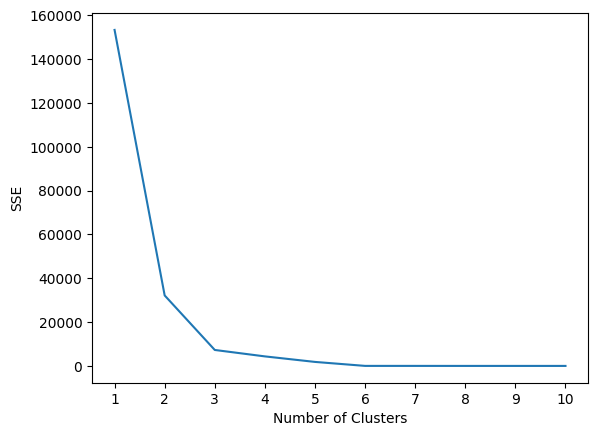

In [11]:
# Importing Modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": None,
}

#create list to hold SSE (sum of squared errors) values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(norm_df)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [12]:
#instantiate the k-means class, using optimal number of clusters
kmeans = KMeans(init="random", n_clusters=3, n_init=10, random_state=1)

#fit k-means algorithm to data
kmeans.fit(norm_df)

#view cluster assignments for each observation
kmeans.labels_

#append cluster assingments to original DataFrame
features_df['cluster'] = kmeans.labels_
norm_df['cluster'] = kmeans.labels_


#view updated DataFrame
features_df

,amount,concept:name_CreateFine,concept:name_SendFine,concept:name_InsertFineNotification,concept:name_Addpenalty,concept:name_SendforCreditCollection,concept:name_Payment,concept:name_InsertDateAppealtoPrefecture,concept:name_SendAppealtoPrefecture,paymentAmount,cluster
0,71.5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,2
1,74.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,87.000000,1
2,74.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,2
3,36.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,36.000000,0
4,36.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,36.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
125449,262.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,2
125450,131.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,146.160004,0
125451,262.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,2
125452,262.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,2


In [13]:
# Extract 'case:concept:name' from filtered_log
case_ids = filtered_log['case:concept:name'].unique()

# Ensure the length matches between features_df and the unique case IDs
if len(features_df) == len(case_ids):
    # Add the 'case:concept:name' column to features_df
    features_df['case:concept:name'] = case_ids
else:
    print("The length of the features_df does not match the number of unique case IDs.")


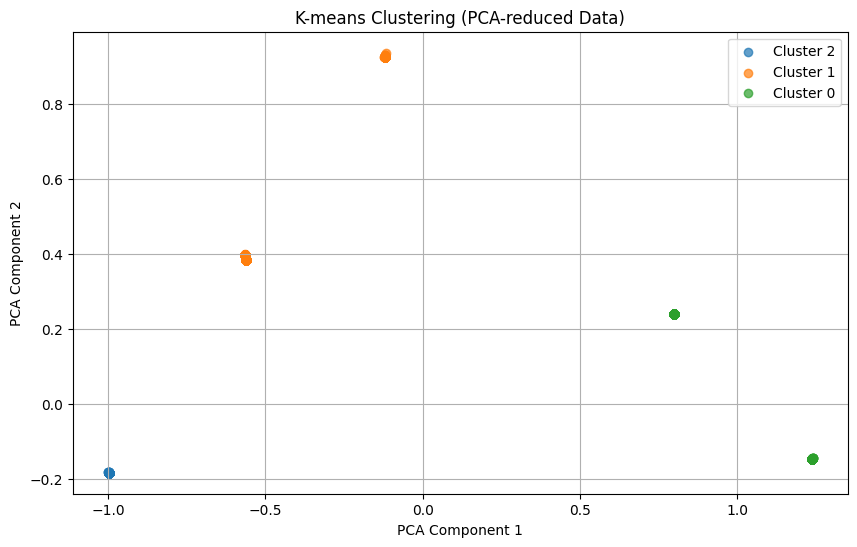

In [14]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



# Separate features and labels
features = norm_df.drop('cluster', axis=1)
cluster_labels = norm_df['cluster']

# Perform PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(features)

# Plotting the clusters
plt.figure(figsize=(10, 6))

# Scatter plot for each cluster
unique_clusters = cluster_labels.unique()
for cluster in unique_clusters:
    plt.scatter(pca_components[cluster_labels == cluster, 0],
                pca_components[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}',
                alpha=0.7)

plt.title('K-means Clustering (PCA-reduced Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Analyzing the clusters
for i in range(3):  
    print(f"Cluster {i}:")
    print(norm_df[norm_df['cluster'] == i].describe())

Cluster 0:
             amount  concept:name_CreateFine  concept:name_SendFine  \
count  49502.000000                  49502.0           49502.000000   
mean       0.004740                      0.0               0.063250   
std        0.002082                      0.0               0.243414   
min        0.000000                      0.0               0.000000   
25%        0.004200                      0.0               0.000000   
50%        0.004375                      0.0               0.000000   
75%        0.004750                      0.0               0.000000   
max        0.099750                      0.0               1.000000   

       concept:name_InsertFineNotification  concept:name_Addpenalty  \
count                              49502.0                  49502.0   
mean                                   0.0                      0.0   
std                                    0.0                      0.0   
min                                    0.0                      0

Number of events in cluster 0: 102135
Number of cases in cluster 0: 49502
Number of events in cluster 1: 107300
Number of cases in cluster 1: 19470
Number of events in cluster 2: 282410
Number of cases in cluster 2: 56482


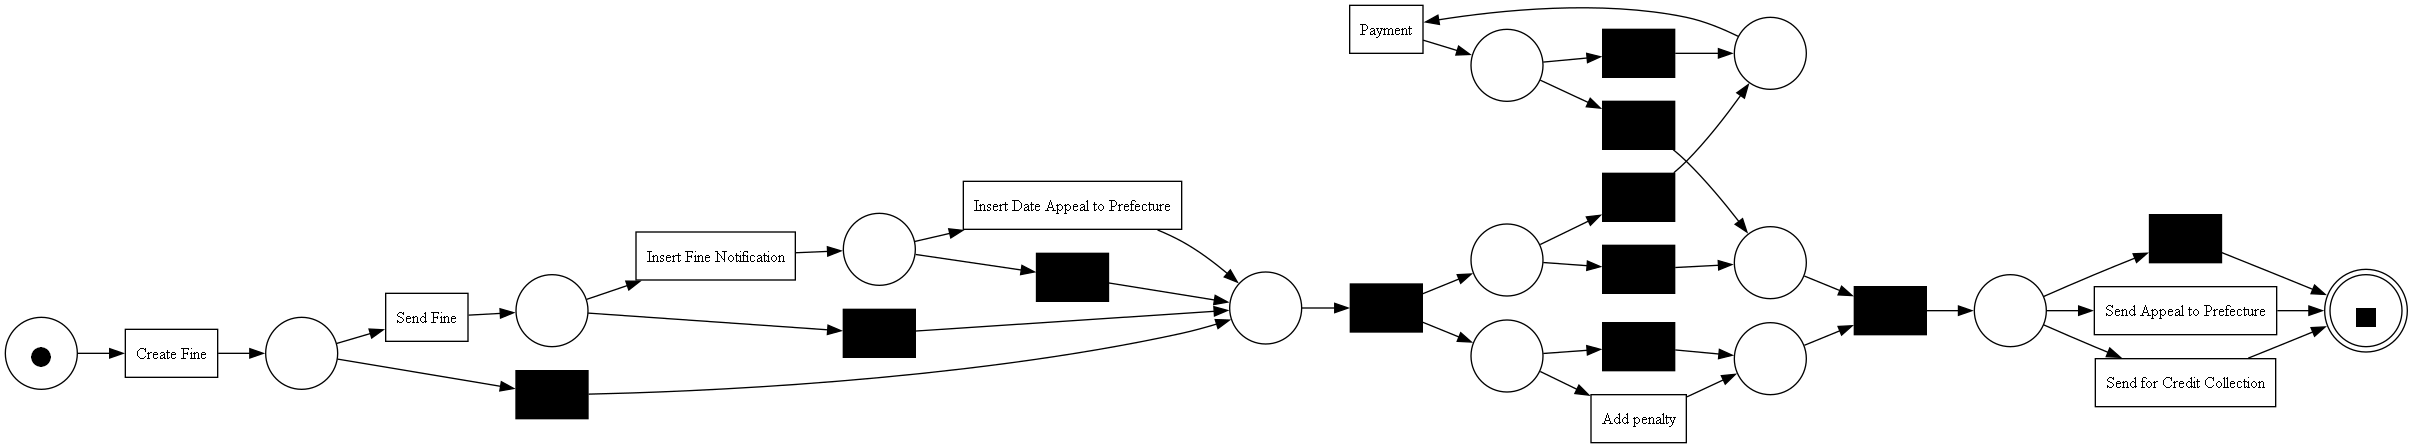

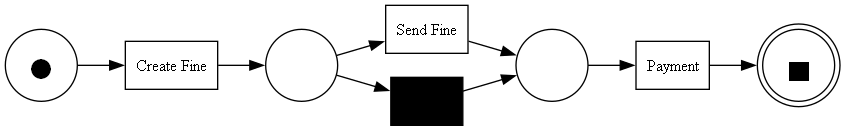

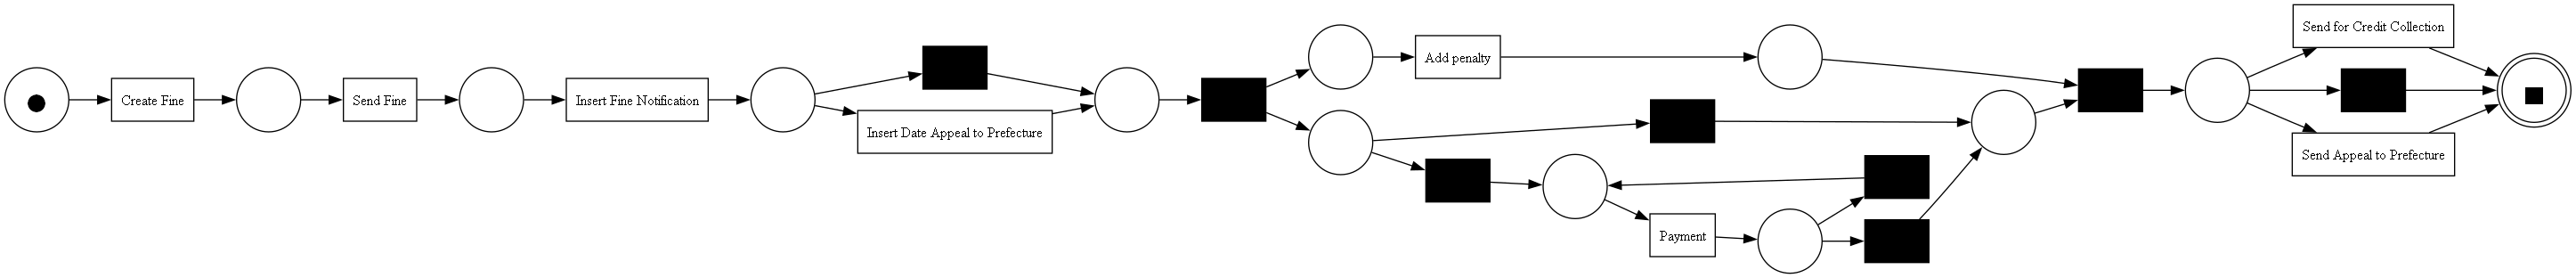

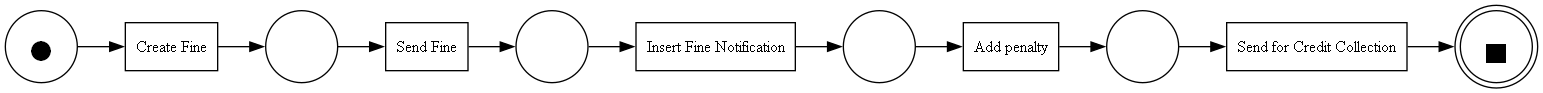

In [16]:
# View event log by cluster

# get the list of cases having 0 as a value of column cluster 
cluster1_cases = features_df[features_df['cluster'] == 0]['case:concept:name'].tolist()
#print(len(cluster1_cases))
# selecting rows based on condition 
cluster1_log = filtered_log[filtered_log['case:concept:name'].isin(cluster1_cases)]

num_events = len(cluster1_log)
num_cases = len(cluster1_log['case:concept:name'].unique())
print("Number of events in cluster 0: {}\nNumber of cases in cluster 0: {}".format(num_events, num_cases))

# get the list of cases having 1 as a value of column cluster 
cluster2_cases = features_df[features_df['cluster'] == 1]['case:concept:name'].tolist()
# selecting rows based on condition 
cluster2_log = filtered_log[filtered_log['case:concept:name'].isin(cluster2_cases)]

num_events = len(cluster2_log)
num_cases = len(cluster2_log['case:concept:name'].unique())
print("Number of events in cluster 1: {}\nNumber of cases in cluster 1: {}".format(num_events, num_cases))

# get the list of cases having 2 as a value of column cluster 
cluster3_cases = features_df[features_df['cluster'] == 2]['case:concept:name'].tolist()
# selecting rows based on condition 
cluster3_log = filtered_log[filtered_log['case:concept:name'].isin(cluster3_cases)]

num_events = len(cluster3_log)
num_cases = len(cluster3_log['case:concept:name'].unique())
print("Number of events in cluster 2: {}\nNumber of cases in cluster 2: {}".format(num_events, num_cases))



# create and visualize the petri net on the filtered_log using inductive miner
net, im, fm = pm4py.discover_petri_net_inductive(filtered_log)
pm4py.view_petri_net(net, im, fm, format='png')

# create and visualize the petri net on clsuter1 using inductive miner
net, im, fm = pm4py.discover_petri_net_inductive(cluster1_log)
pm4py.view_petri_net(net, im, fm, format='png')

# create and visualize the petri net on clsuter2 using inductive miner
net, im, fm = pm4py.discover_petri_net_inductive(cluster2_log)
pm4py.view_petri_net(net, im, fm, format='png')

# create and visualize the petri net on clsuter3 using inductive miner
net, im, fm = pm4py.discover_petri_net_inductive(cluster3_log)
pm4py.view_petri_net(net, im, fm, format='png')


In [68]:
df.columns

Index(['amount', 'org:resource', 'dismissal', 'concept:name', 'vehicleClass',
       'totalPaymentAmount', 'lifecycle:transition', 'time:timestamp',
       'article', 'points', 'case:concept:name', 'expense', 'notificationType',
       'lastSent', 'paymentAmount', 'matricola', 'start_timestamp'],
      dtype='object')

In [159]:
''' should be check which column should be chosen for the categorization and the list of categories should be modified
 with the unique values of the chosen column '''


def categorizeLogFile(log, categories):
    return {
        item: log[log['vehicleClass'] == item]
        for item in categories
    }

segmentedData = categorizeLogFile(log, ["A", "C", "M","R"])


In [160]:
def filter(input):
    log = input.copy()
    print("Number of cases before case performance filter:", len(log))
    log = pm4py.filter_case_performance(log, 0, 18144000)
    print("Number of cases after case performance filter:", len(log))
    log = pm4py.filter_variants_top_k(log, k)
    print("Number of cases after top k variants filter:", len(log))
    log = pm4py.filter_start_activities(log,["Create Fine"])
    print("Number of cases after start activities filter:", len(log))
    
    # Print intermediate results for dynamic strategy
    sorted_values = sorted(log_end.values(), reverse=True)
    print("Sorted values:", sorted_values)
    
    percentage_threshold = 80
    threshold_index = int(len(sorted_values) * (percentage_threshold / 100))
    threshold_value = sorted_values[threshold_index - 1] if threshold_index > 0 else 0
    print("Percentage threshold:", percentage_threshold)
    print("Threshold value:", threshold_value)
    
    filtered_log_end = [key for key, value in log_end.items() if value >= threshold_value]
    print("Filtered end activities:", filtered_log_end)
    
    # log = pm4py.filter_end_activities(log, filtered_log_end)
    print("Number of cases after end activities filter:", len(log))
    
    cases_to_exclude = pd.concat([
        pm4py.filter_activities_rework(log, "Send Fine", 2),
        pm4py.filter_activities_rework(log, "Send for Credit Collection", 2)
        ])
    cases_to_exclude = cases_to_exclude["case:concept:name"].unique()
    print("Cases to exclude:", len(cases_to_exclude))
    
    total_cases = len(log["case:concept:name"].unique())
    print("Total cases after filtering:", total_cases)
    
    # Remove excluded cases
    log = log[~log['case:concept:name'].isin(cases_to_exclude)]
    print("Total cases after excluding rework cases:", len(log["case:concept:name"].unique()))
    
    return log

for item in segmentedData:
    print("Number of cases in", item, "before filtering:", len(segmentedData[item]["case:concept:name"].unique()))
    segmentedData[item] = filter(segmentedData[item])
    print("Number of cases in", item, "after filtering:", len(segmentedData[item]["case:concept:name"].unique()))
    print("\n")


Number of cases in A before filtering: 146712
Number of cases before case performance filter: 146712
Number of cases after case performance filter: 146712
Number of cases after top k variants filter: 146712
Number of cases after start activities filter: 146712
Sorted values: [67201, 58997, 20755, 3144, 134, 86, 53]
Percentage threshold: 80
Threshold value: 134
Filtered end activities: ['Send Fine', 'Send for Credit Collection', 'Payment', 'Send Appeal to Prefecture', 'Appeal to Judge']
Number of cases after end activities filter: 146712
Cases to exclude: 0
Total cases after filtering: 146712
Total cases after excluding rework cases: 146712
Number of cases in A after filtering: 146712


Number of cases in C before filtering: 2456
Number of cases before case performance filter: 2456
Number of cases after case performance filter: 2456
Number of cases after top k variants filter: 2456
Number of cases after start activities filter: 2456
Sorted values: [67201, 58997, 20755, 3144, 134, 86, 53

In [161]:
# categories = ["A", "C", "M","R"]
# values = [1044, 677, 15182, 9068, 221010, 194933, 14498, 12501]
# colors = ['blue', 'blue', 'green', 'green', 'orange', 'orange', 'purple', 'purple']
# plt.figure(figsize=(15, 5))
# bars = plt.barh(categories, values, color=colors)
# for bar, value in zip(bars, values):
#     plt.text(value, bar.get_y() + bar.get_height() / 2, str(value), ha='left', va='center')

# plt.xlabel('Number of Cases')
# plt.ylabel('Categories')
# plt.title('Cases Comparison')
# plt.show()

In [162]:
# categories = [
#     '2-way match before filtering',
#     '2-way match after filtering',
#     '3-way match, invoice after GR before filtering',
#     '3-way match, invoice after GR after filtering',
#     '3-way match, invoice before GR before filtering',
#     '3-way match, invoice before GR after filtering',
#     'Consignment before filtering',
#     'Consignment after filtering'
# ]
# values = [1044, 677, 15182, 9068, 221010, 194933, 14498, 12501]
# colors = ['blue', 'blue', 'green', 'green', 'orange', 'orange', 'purple', 'purple']
# plt.figure(figsize=(15, 5))
# bars = plt.barh(categories, values, color=colors)
# for bar, value in zip(bars, values):
#     plt.text(value, bar.get_y() + bar.get_height() / 2, str(value), ha='left', va='center')

# plt.xlabel('Number of Cases')
# plt.ylabel('Categories')
# plt.title('Cases Comparison')
# plt.show()

In [ ]:
#for the 3-way match, invoice after GR, it should contains "Record Goods Receipt" and also "Record Invoice Receipt"
segmentedData["3-way match, invoice after GR"] = pm4py.filter_activities_rework(segmentedData["3-way match, invoice after GR"], "Record Invoice Receipt", 1)
segmentedData["3-way match, invoice after GR"] = pm4py.filter_activities_rework(segmentedData["3-way match, invoice after GR"], "Record Goods Receipt", 1)
print("size of \"3-way match, invoice after GR\" after filter:",len(segmentedData["3-way match, invoice after GR"]["case:concept:name"].unique()))

In [ ]:
#for the 3-way matching, invoice before goods receipt, it should contains "Record Goods Receipt"
segmentedData["3-way match, invoice before GR"] = pm4py.filter_activities_rework(segmentedData["3-way match, invoice before GR"], "Record Goods Receipt", 1)
print("size of \"3-way match, invoice before GR\" after filter:",len(segmentedData["3-way match, invoice before GR"]["case:concept:name"].unique()))

In [ ]:
for item in segmentedData:
  print(item)

In [ ]:
#alpha miner
alpha_miner_heatmap = {}
for item in segmentedData:
  net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(segmentedData[item])
  pm4py.view_petri_net(net, initial_marking, final_marking)

  fitness = pm4py.fitness_token_based_replay(segmentedData[item], net, initial_marking, final_marking)
  precision = pm4py.precision_token_based_replay(segmentedData[item], net, initial_marking, final_marking)
  generalization = generalization_evaluator.apply(segmentedData[item], net, initial_marking, final_marking)
  simplicity = simplicity_evaluator.apply(net)

  alpha_miner_heatmap[item] = [fitness["log_fitness"],precision,generalization,simplicity]

  print("replay based fitness:", fitness)
  print("replay based precision:", precision)
  print("generalization:",generalization)
  print("simplicity:",simplicity)

In [ ]:
# inductive minder:
inductive_miner_heatmap = {}
for item in segmentedData:
  net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(segmentedData[item])
  pm4py.view_petri_net(net, initial_marking, final_marking)

  fitness = pm4py.fitness_token_based_replay(segmentedData[item], net, initial_marking, final_marking)
  precision = pm4py.precision_token_based_replay(segmentedData[item], net, initial_marking, final_marking)
  generalization = generalization_evaluator.apply(segmentedData[item], net, initial_marking, final_marking)
  simplicity = simplicity_evaluator.apply(net)

  inductive_miner_heatmap[item] = [fitness["log_fitness"],precision,generalization,simplicity]

  print("replay based fitness:", fitness)
  print("replay based precision:", precision)
  print("generalization:",generalization)
  print("simplicity:",simplicity)

In [ ]:
#Heuristic miner:
heuristic_miner_heatmap = {}
for item in segmentedData:
  net, initial_marking, final_marking = pm4py.discover_petri_net_heuristics(segmentedData[item], dependency_threshold=0.99,and_threshold = 0.99,loop_two_threshold=0.99)
  pm4py.view_petri_net(net, initial_marking, final_marking)

  fitness = pm4py.fitness_token_based_replay(segmentedData[item], net, initial_marking, final_marking)
  precision = pm4py.precision_token_based_replay(segmentedData[item], net, initial_marking, final_marking)
  generalization = generalization_evaluator.apply(segmentedData[item], net, initial_marking, final_marking)
  simplicity = simplicity_evaluator.apply(net)

  heuristic_miner_heatmap[item] = [fitness["log_fitness"],precision,generalization,simplicity]

  print("replay based fitness:", fitness)
  print("replay based precision:", precision)
  print("generalization:",generalization)
  print("simplicity:",simplicity)

In [ ]:
# drawing heatmap to check performance of each algorithm for each category
x_labels = ["fitness", "precision", "generalization", "simplicity"]
y_labels = ["alpha miner","inductive miner","heuristic miner"]
y_ticks = list(alpha_miner_heatmap.keys())
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 12))
for i, key in enumerate(alpha_miner_heatmap.keys()):
    row = i // 2
    col = i % 2
    values = [alpha_miner_heatmap[key], inductive_miner_heatmap[key], heuristic_miner_heatmap[key]]
    values = np.round(values, decimals=2)
    ax = axes[row, col]
    im = ax.imshow(values, cmap='hot', vmin=0, vmax=1)
    ax.set_title(key)
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticks(np.arange(len(values)))
    ax.set_yticklabels(["alpha_miner_heatmap", "inductive_miner_heatmap", "heuristic_miner_heatmap"])
    for i in range(len(values)):
        for j in range(len(x_labels)):
            text = ax.text(j, i, values[i][j], ha="center", va="center", color="black")
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
cbar.ax.set_ylabel('Values')
plt.show()